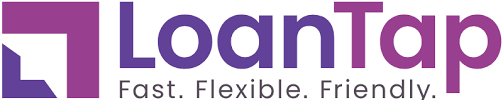

## Problem Statement

LoanTap aims to strengthen its underwriting process for Personal Loans by leveraging data-driven decision-making. The goal is to analyze customer attributes and financial behavior to build a robust creditworthiness model that helps determine whether a credit line should be extended to an individual.

The analysis will focus on:

Identifying Key Predictors – Determining the most significant demographic, financial, and behavioral factors that influence loan approval decisions.

Creditworthiness Assessment – Developing a predictive framework to classify individuals as eligible or ineligible for a personal loan.

Risk Profiling – Segmenting applicants into low, medium, and high-risk categories based on repayment capability and default probability.

Business Recommendations – Suggesting optimal repayment terms (tenure, EMI flexibility, interest rates) tailored to each risk profile to minimize default risk while ensuring customer satisfaction.

Through this analysis, LoanTap can improve loan approval efficiency, reduce risk exposure, and enhance customer experience by offering customized repayment solutions for personal loans.

## Import Libraries

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind,chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay,f1_score,recall_score,precision_score
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [135]:
df = pd.read_csv('logistic_regression.csv')

## Exploratory Data Analysis

In [136]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [137]:
# Shape of Data
df.shape

(396030, 27)

In [138]:
# Data TYpe
df.dtypes

,0
loan_amnt,float64
term,object
int_rate,float64
installment,float64
grade,object
sub_grade,object
emp_title,object
emp_length,object
home_ownership,object
annual_inc,float64


In [139]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [140]:
df.nunique()

,0
loan_amnt,1397
term,2
int_rate,566
installment,55706
grade,7
sub_grade,35
emp_title,173105
emp_length,11
home_ownership,6
annual_inc,27197


In [141]:
df.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [142]:
# convert term column to category and remove months character from it
df['term'] = df['term'].str.replace(' months', '')
df['term'] = df['term'].astype('category')

In [143]:
# Convert grade to category
df['grade'] = df['grade'].astype('category')
# Convert Subgrade to category
df['sub_grade'] = df['sub_grade'].astype('category')
# Cpmvert home_ownership to category
df['home_ownership'] = df['home_ownership'].astype('category')
# Convert verification_status to category
df['verification_status'] = df['verification_status'].astype('category')
# Convert loan_status to category
df['loan_status'] = df['loan_status'].astype('category')
# Convert purpose to category
df['purpose'] = df['purpose'].astype('category')
# Convert initial_list_status to category
df['initial_list_status'] = df['initial_list_status'].astype('category')
# convert application type to category
df['application_type'] = df['application_type'].astype('category')

In [144]:
# Missing value detection
df.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,22927
emp_length,18301
home_ownership,0
annual_inc,0


In [145]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [146]:
# Statistical summary of categorical data
df.describe(include='object').T

,count,unique,top,freq
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
issue_d,396030,115,Oct-2014,14846
title,394274,48816,Debt consolidation,152472
earliest_cr_line,396030,684,Oct-2000,3017
address,396030,393700,USS Johnson\r\nFPO AE 48052,8


## Univariate Analysis


In [147]:
# univariate Analysis of categorical features
df.select_dtypes(include='object').describe().T
#

,count,unique,top,freq
emp_title,373103,173105,Teacher,4389
emp_length,377729,11,10+ years,126041
issue_d,396030,115,Oct-2014,14846
title,394274,48816,Debt consolidation,152472
earliest_cr_line,396030,684,Oct-2000,3017
address,396030,393700,USS Johnson\r\nFPO AE 48052,8


### **Duplicate Detection**

In [148]:
df[df.duplicated()]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address


#### Insights

- The dataset does not contain any duplicates.
-----
###**Null Detection**

In [149]:
df.isna().any()[df.isna().any()]

,0
emp_title,True
emp_length,True
title,True
revol_util,True
mort_acc,True
pub_rec_bankruptcies,True


In [150]:
df.isna().sum().sort_values(ascending=False)

,0
mort_acc,37795
emp_title,22927
emp_length,18301
title,1756
pub_rec_bankruptcies,535
revol_util,276
installment,0
int_rate,0
term,0
grade,0


In [151]:
def missing_data(df):
    total_missing_df = df.isnull().sum().sort_values(ascending =False)
    percent_missing_df = (df.isnull().sum()/df.isna().count()*100).sort_values(ascending=False)
    missing_data_df = pd.concat([total_missing_df, percent_missing_df], axis=1, keys=['Total', 'Percent'])
    return missing_data_df

missing_pct = missing_data(df)
missing_pct[missing_pct['Total']>0]

,Total,Percent
mort_acc,37795,9.543469
emp_title,22927,5.789208
emp_length,18301,4.621115
title,1756,0.443401
pub_rec_bankruptcies,535,0.135091
revol_util,276,0.069692


#### Insight

> Following columns has missing values
1. emp_title has 5.78% missing values
2. emp_length has 4.62% missing values
3. title has 0.43% missing values
4. revol_until has 0.07% missing values
5. mort_acc has 9.56% missing values
6. pub_rec_bankruptcies has 0.13% missing values

> Action  

- Since ML algorithm do not work on columns which has missing values so we need to impute these missing values.

In [152]:
df.isna().sum().sum()
# since there are 67446 rows are null , we cant drop na ...

np.int64(81590)

In [153]:
#checking the unique values for columns
for _ in df.columns:
    print()
    print(f'Total Unique Values in {_} column are :- {df[_].nunique()}')
    print(f'Unique Values in {_} column are :-\n {df[_].unique()}')
    print(f'Value_counts of {_} column :-\n {df[_].value_counts()}')
    print()
    print('-'*120)


Total Unique Values in loan_amnt column are :- 1397
Unique Values in loan_amnt column are :-
 [10000.  8000. 15600. ... 36275. 36475.   725.]
Value_counts of loan_amnt column :-
 loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
39200.0        1
38750.0        1
36275.0        1
36475.0        1
725.0          1
Name: count, Length: 1397, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in term column are :- 2
Unique Values in term column are :-
 [' 36', ' 60']
Categories (2, object): [' 36', ' 60']
Value_counts of term column :-
 term
36    302005
60     94025
Name: count, dtype: int64

------------------------------------------------------------------------------------------------------------------------

Total Unique Values in int_rate column are :- 566
Unique Values in int_rate column are :-
 [11.44 11.99 10.49  6.

## Null Treatment:

In [154]:
df.loc[df['revol_util'].isna(), 'revol_util'] = 0.0
df.loc[df['mort_acc'].isna(), 'mort_acc'] = 0.0
df.loc[df['pub_rec_bankruptcies'].isna(), 'pub_rec_bankruptcies'] = 0.0
df.loc[df['emp_title'].isna(), 'emp_title'] = 'No Employee Title'
df.loc[df['title'].isna(), 'title'] = 'Unavailable'
df['emp_length'] = df['emp_length'].fillna('< 1 year')
df.loc[df['home_ownership'].isna(), 'home_ownership'] = 'ANY'
df.loc[df['annual_inc'].isna(), 'annual_inc'] = 0.0
df.loc[df['verification_status'].isna(), 'verification_status'] = 'Not Verified'
df.loc[df['issue_d'].isna(), 'issue_d'] = 'Oct-2014'
df.loc[df['loan_status'].isna(), 'loan_status'] = 'Fully Paid'
df.loc[df['purpose'].isna(), 'purpose'] = 'debt_consolidation'
df.loc[df['dti'].isna(), 'dti'] = 0.0
df.loc[df['earliest_cr_line'].isna(), 'earliest_cr_line'] = 'Oct-2000'
df.loc[df['address'].isna(), 'address'] = 'USCGC Miller\r\nFPO AE 22690'
df.loc[df['open_acc'].isna(), 'open_acc'] = 0.0
df.loc[df['pub_rec'].isna(), 'pub_rec'] = 0.0
df.loc[df['revol_bal'].isna(), 'revol_bal'] = 0.0


In [155]:
df.isna().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


In [156]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,396030.0,53.754260,24.484857,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [157]:
df.describe(include='object').T

,count,unique,top,freq
emp_title,396030,173106,No Employee Title,22927
emp_length,396030,11,10+ years,126041
issue_d,396030,115,Oct-2014,14846
title,396030,48817,Debt consolidation,152472
earliest_cr_line,396030,684,Oct-2000,3017
address,396030,393700,USS Johnson\r\nFPO AE 48052,8


### Feature Engineering

In [158]:
df['pub_rec'] = [1 if i > 1 else 0 for i in df['pub_rec']]
df['mort_acc'] = [1 if i > 1 else 0 for i in df['mort_acc']]
df['pub_rec_bankruptcies'] = [1 if i > 1 else 0 for i in df['pub_rec_bankruptcies']]

In [159]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
141742,9500.0,36,7.89,297.22,A,A5,manager,10+ years,MORTGAGE,90000.0,...,15.0,0,14537.0,11.5,29.0,w,INDIVIDUAL,1,0,"31527 Martin Skyway Apt. 691\r\nJasonmouth, AR..."


In [160]:
#Split issue_date into month and year
df[['issue_month', 'issue_year']] = df['issue_d'].str.split('-', expand=True)
df.drop(['issue_d'], axis=1, inplace=True)

In [161]:
#Split er_cr_line date into month and year
df[['er_cr_line_m', 'er_cr_line_y']] = df['earliest_cr_line'].str.split('-', expand=True)
df.drop(['earliest_cr_line'], axis=1, inplace=True)

In [162]:
df['address']

,address
0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,"679 Luna Roads\r\nGreggshire, VA 11650"
...,...
396025,"12951 Williams Crossing\r\nJohnnyville, DC 30723"
396026,"0114 Fowler Field Suite 028\r\nRachelborough, ..."
396027,"953 Matthew Points Suite 414\r\nReedfort, NY 7..."
396028,"7843 Blake Freeway Apt. 229\r\nNew Michael, FL..."


In [163]:
#Split address into State and Zip code
import re
df[['state','zipcode']] = df['address'].str.extract(r'([A-Z]{2}) (\d{5})')
df.drop(['address'], axis=1, inplace=True)

In [164]:
df['state'].nunique() , df['zipcode'].nunique()

(54, 10)

In [165]:
df['state'].isna().sum() , df['zipcode'].isna().sum()

(np.int64(0), np.int64(0))

In [166]:
df['emp_length_yrs'] = df['emp_length'].str.extract('(\d+)')
df.drop(['emp_length'], axis=1, inplace=True)

In [167]:
df['term'] = df['term'].str.split().str[0].astype('object')

In [168]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
190117,9000.0,36,15.61,314.69,C,C3,Letter Carrier,MORTGAGE,58000.0,Verified,...,INDIVIDUAL,1,0,Nov,2013,Jun,1987,MS,05113,10


In [169]:
df.shape

(396030, 30)

In [170]:
# List of categorical columns
cat_cols = df.select_dtypes(include='object')

# List of numerical columns
num_cols = df.select_dtypes(exclude=['object','category'])

In [171]:
cat_cols.sample(3)

,term,emp_title,title,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
37942,36,Director,Credit card refinancing,Jun,2014,May,1979,AA,70466,10
314273,36,Mechanical Assembler,Vacation,May,2015,Aug,2008,DC,70466,2
62001,60,Security Advisor Specialist,Debt consolidation,May,2015,Mar,2007,NC,70466,2


In [172]:
num_cols.sample(3)

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
128931,5000.0,11.49,164.86,65000.0,7.16,11.0,0,3906.0,12.2,39.0,0,0
172580,15000.0,11.99,498.15,57000.0,15.07,14.0,0,18682.0,48.3,22.0,0,0
262512,5000.0,13.99,170.87,25000.0,9.03,11.0,0,3344.0,63.1,15.0,0,0


In [173]:
num_cols.skew()

,0
loan_amnt,0.777285
int_rate,0.420669
installment,0.983598
annual_inc,41.042725
dti,431.051225
open_acc,1.213019
pub_rec,6.812303
revol_bal,11.727515
revol_util,-0.074238
total_acc,0.864328


#### Insights
- Features are Right skewed

#### Action
- Need to apply log transformations in order to normalise them

-----


In [174]:
df1 = df.copy()

In [175]:
df1.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
297535,10000.0,36,12.35,333.82,B,B4,Honda of Ocala,MORTGAGE,29000.0,Verified,...,INDIVIDUAL,0,0,Jul,2013,Oct,2005,WV,29597,6


## Q1. What percentage of customers have fully paid their Loan Amount?

In [176]:
df['loan_status'].value_counts(normalize=True)*100

,proportion
loan_status,
Fully Paid,80.387092
Charged Off,19.612908


### Insights:

- Target variable distribution is 80%-20%. Data is **`significantly imbalanced`**
-----

## Graphical Analysis:
uni / bi / multi variate Analysis

In [177]:
cp = ['indigo','m','darkviolet','magenta','mediumorchid','violet','purple','orchid','mediumpurple','deeppink','blueviolet','darkmagenta','fuchsia']

In [178]:
num_cols.iloc[:,[0,2,3,4,5,6,8,9,10]].sample()

,loan_amnt,installment,annual_inc,dti,open_acc,pub_rec,revol_util,total_acc,mort_acc
159459,6400.0,221.39,86000.0,14.81,9.0,0,48.3,22.0,1


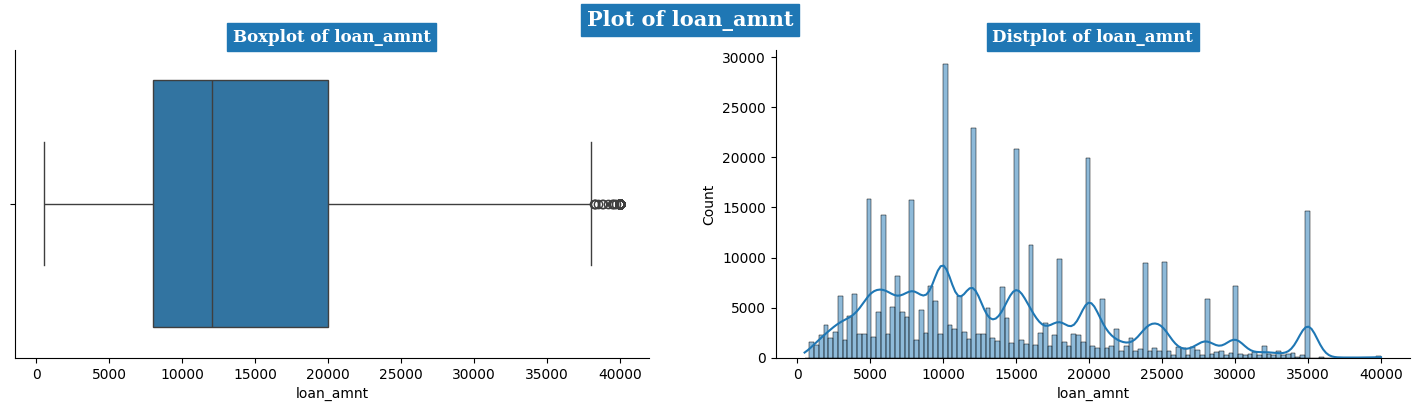

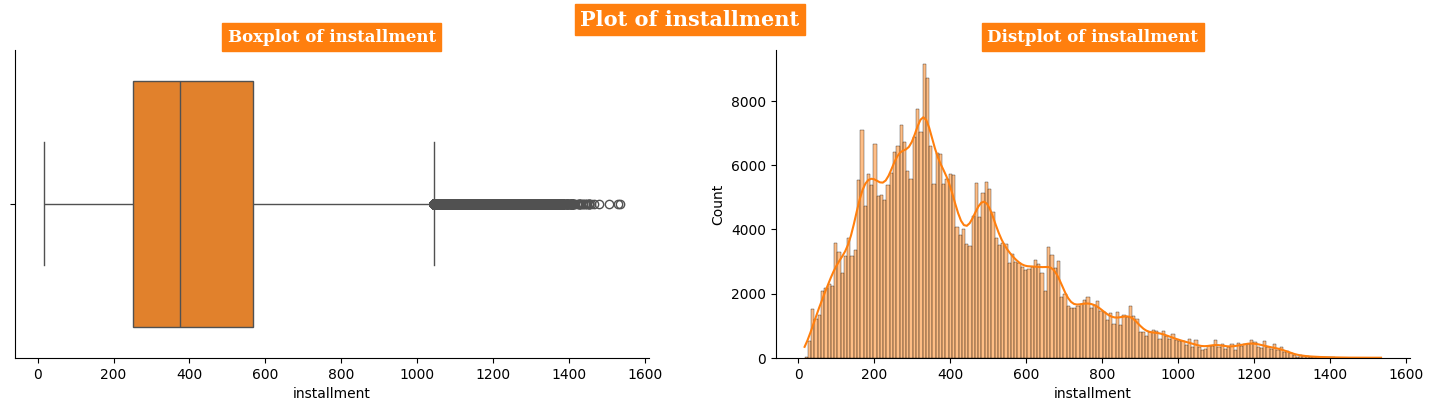

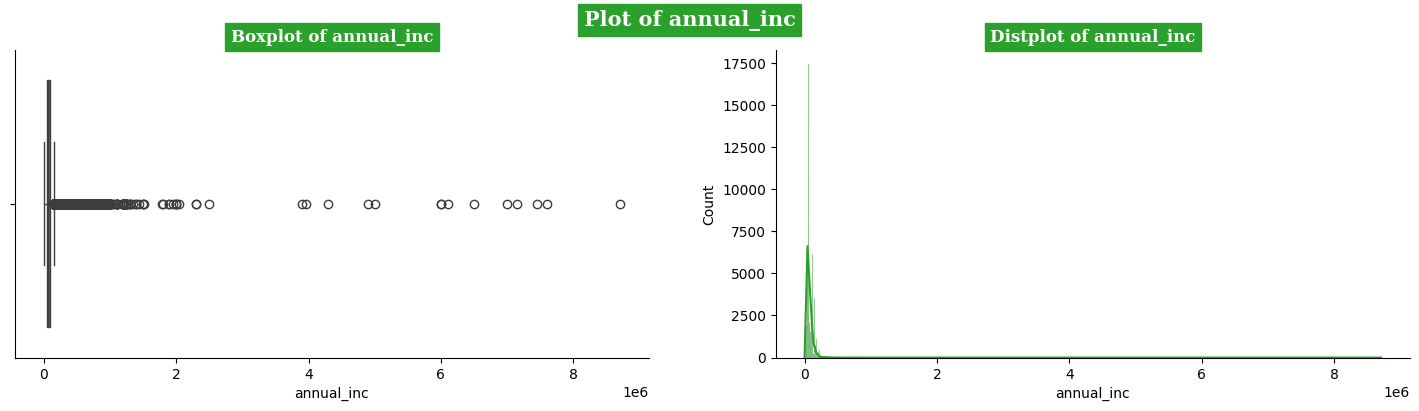

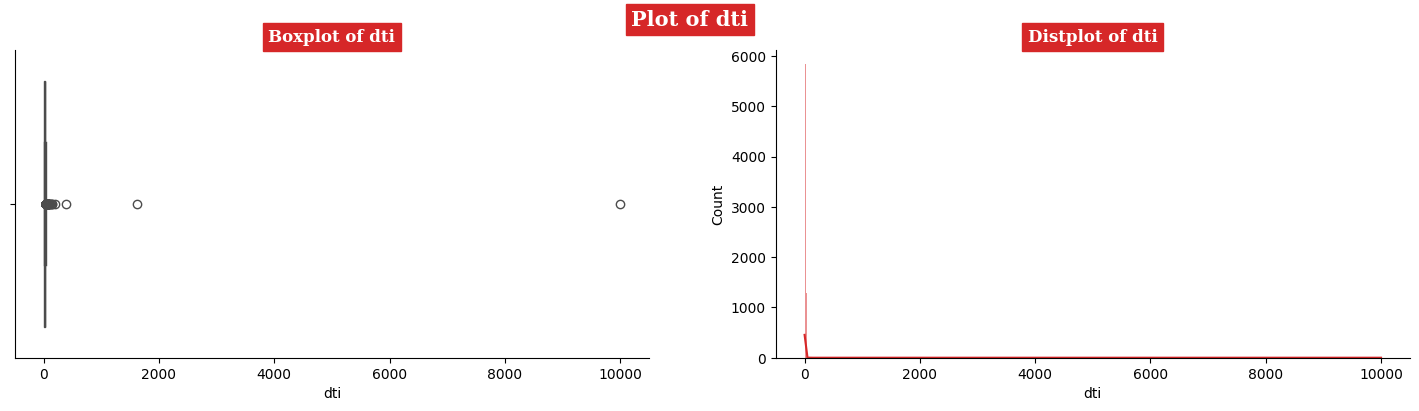

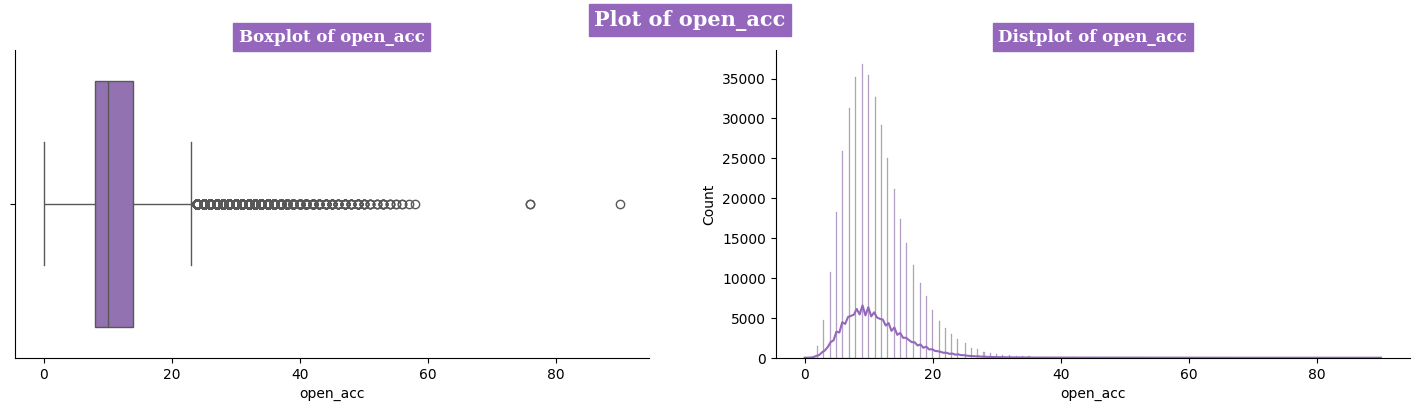

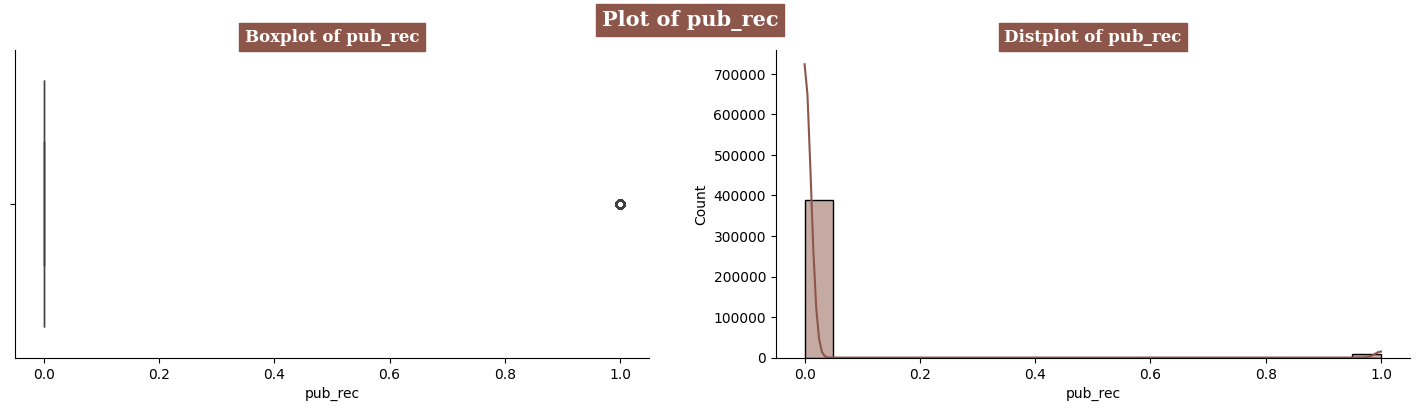

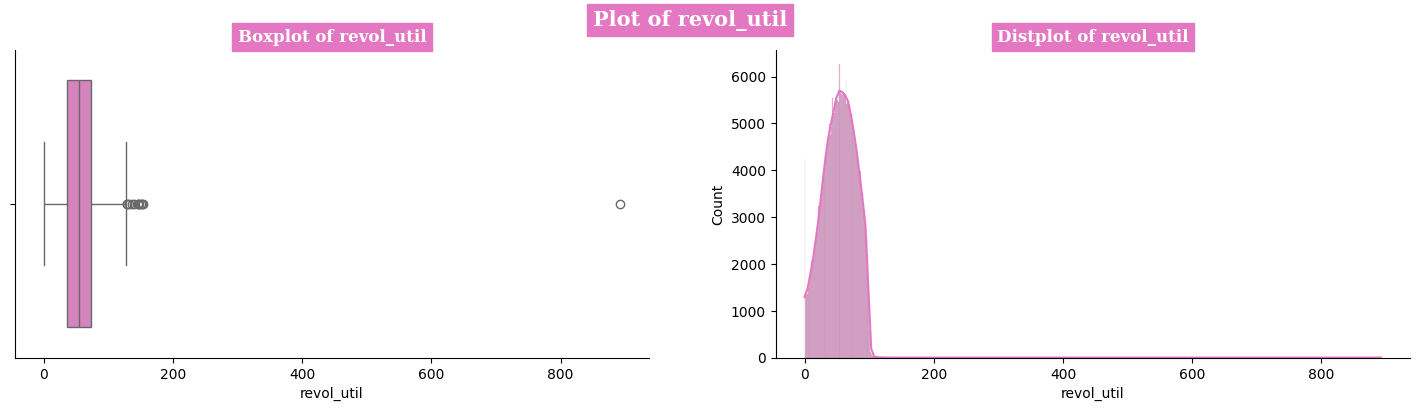

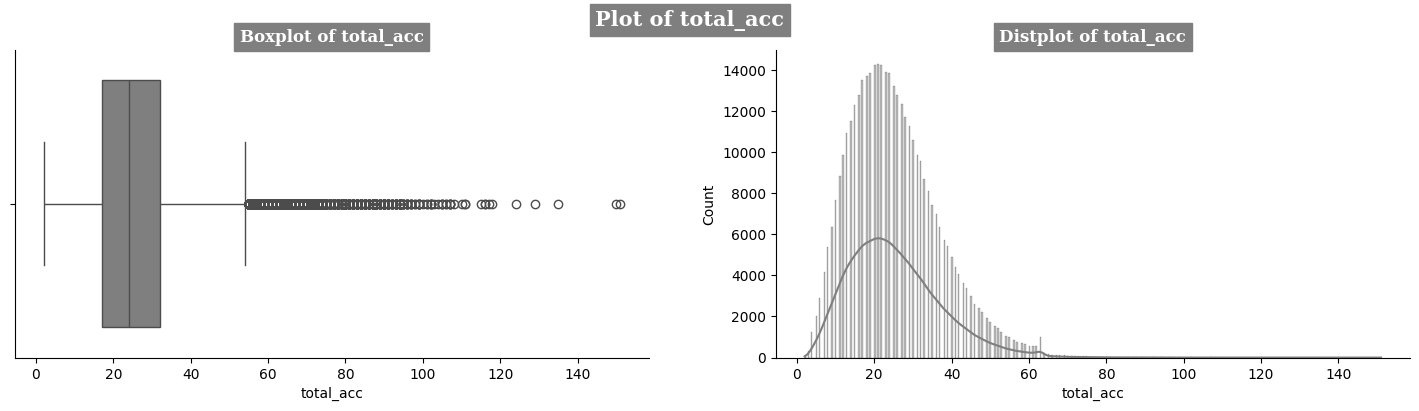

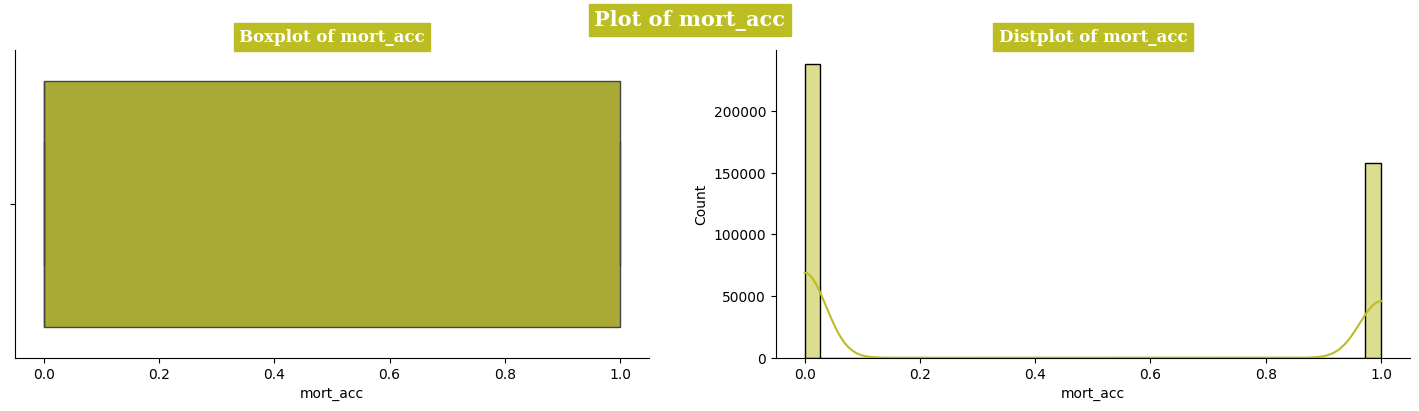

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your own color palette
cp = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
      '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.style.use('default')
plt.style.use('seaborn-v0_8-bright')

outlier_graphical_cols = num_cols.iloc[:, [0,2,3,4,5,6,8,9,10]]

for i, col in enumerate(outlier_graphical_cols.columns):
    plt.figure(figsize=(18,4))
    plt.suptitle(f'Plot of {col}', fontsize=15, fontfamily='serif',
                 fontweight='bold', backgroundcolor=cp[i % len(cp)], color='w')

    plt.subplot(121)
    sns.boxplot(x=df[col], color=cp[i % len(cp)])
    plt.title(f'Boxplot of {col}', fontsize=12, fontfamily='serif',
              fontweight='bold', backgroundcolor=cp[i % len(cp)], color='w')

    plt.subplot(122)
    sns.histplot(x=df[col], kde=True, color=cp[i % len(cp)])
    plt.title(f'Distplot of {col}', fontsize=12, fontfamily='serif',
              fontweight='bold', backgroundcolor=cp[i % len(cp)], color='w')

    sns.despine()
    plt.show()


In [180]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### Insights:

1. The analysis suggests a prevalence of outliers, prompting further investigation into outlier detection techniques.
2. Among the numerical features, Potential outliers may still be present.
3. Notably, features such as Pub_rec, Mort_acc, and Pub_rec_bankruptcies display a sparse distribution of unique values, indicating the potential benefit of generating binary features from these variables.

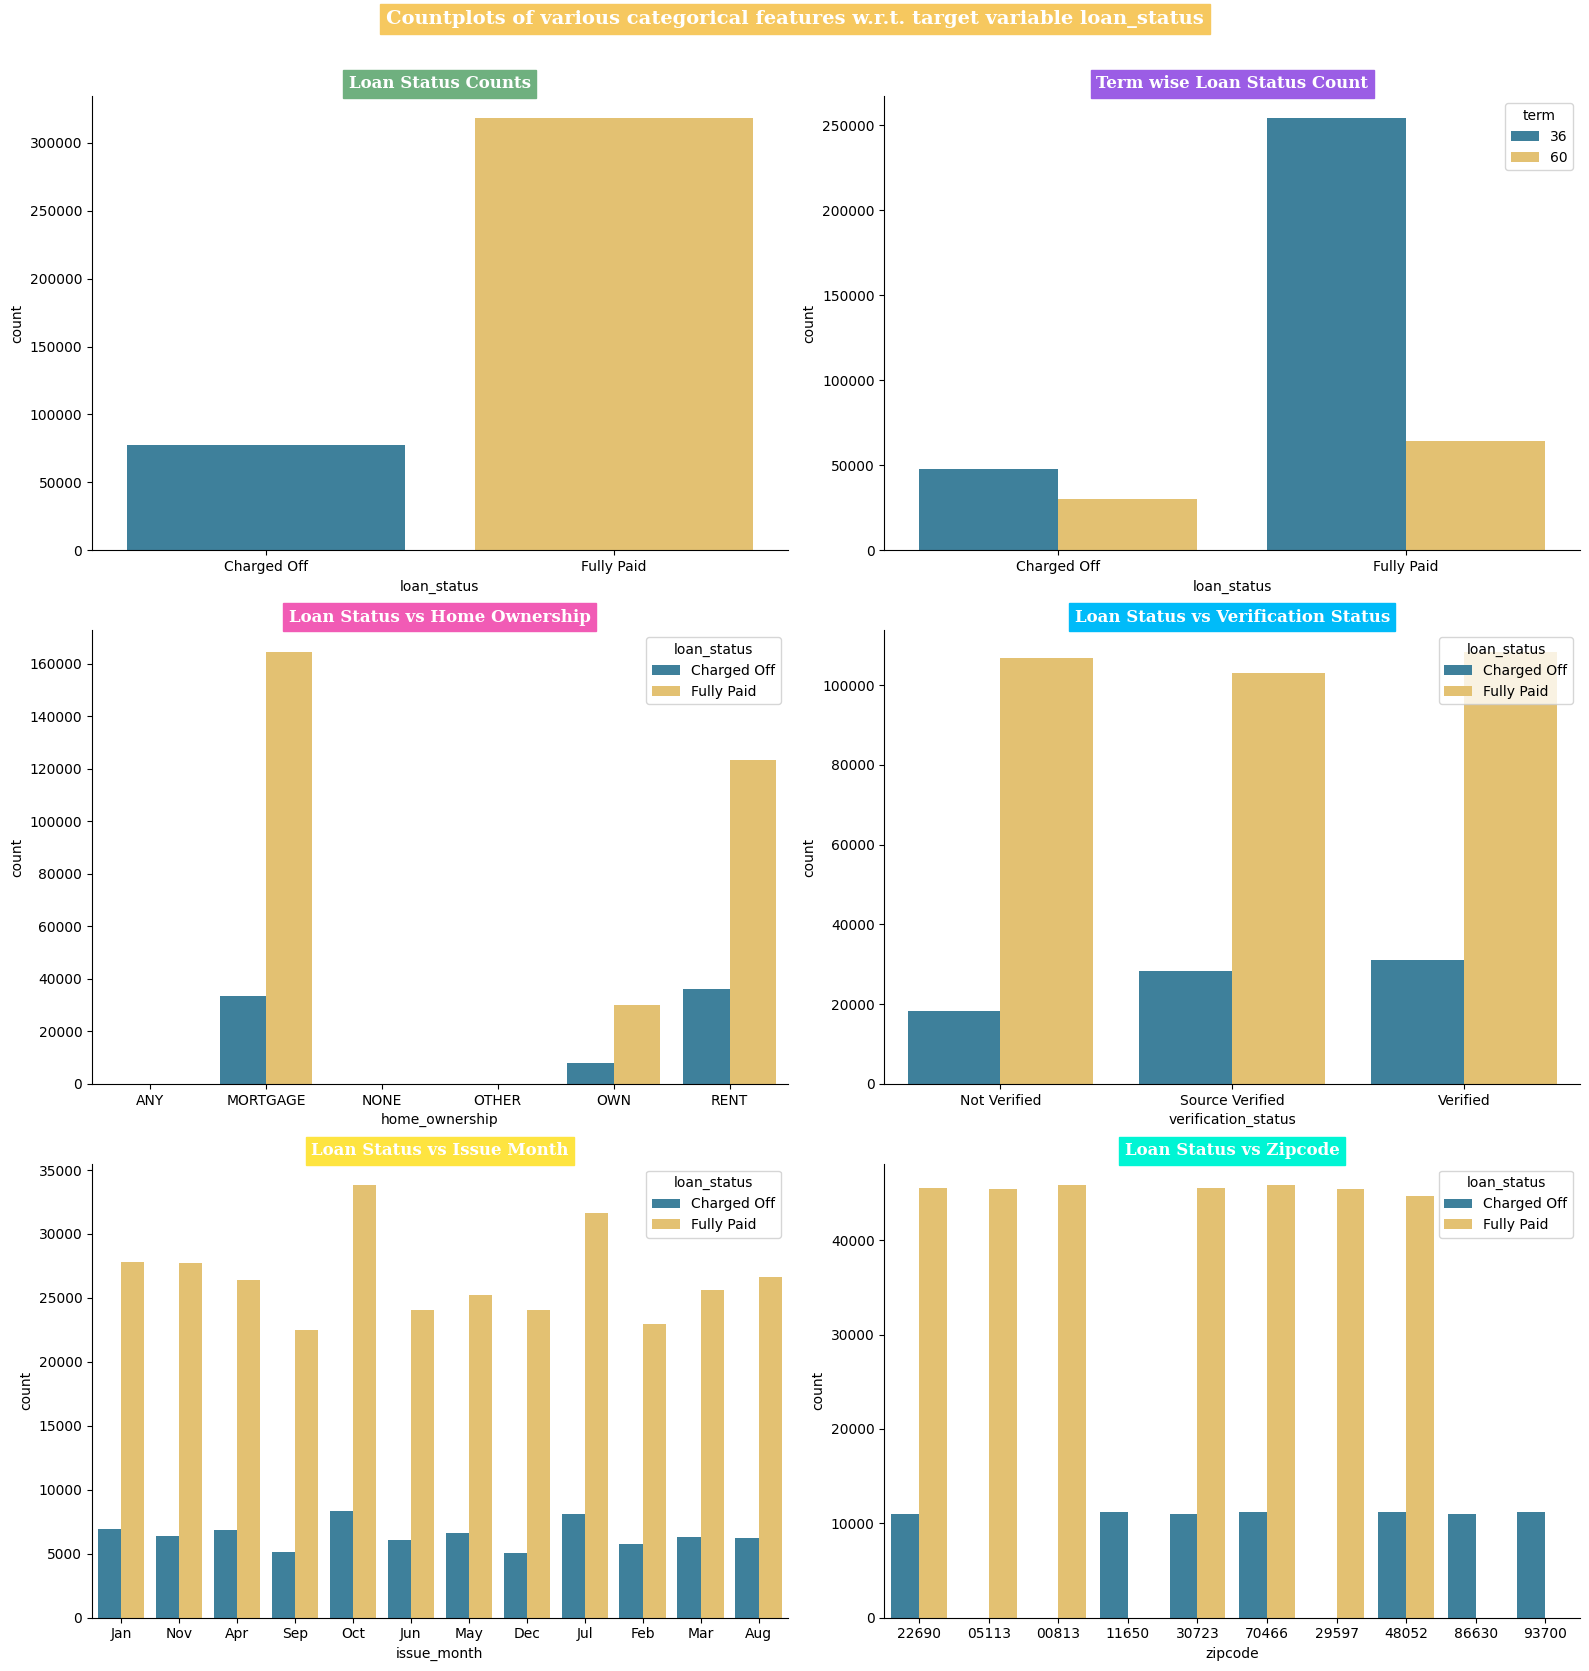

In [248]:
# Define a bright, modern color palette
cp = ['#2E86AB', '#F6C85F', '#6FB07F', '#9B5DE5',
      '#F15BB5', '#00BBF9', '#FEE440', '#00F5D4']

plt.style.use('default')
plt.style.use('seaborn-v0_8-bright')

plt.figure(figsize=(16, 17))
plt.suptitle(
    'Countplots of various categorical features w.r.t. target variable loan_status',
    fontsize=14, fontfamily='serif', fontweight='bold',
    backgroundcolor=cp[1], color='white'
)

# 1️⃣ Loan Status
plt.subplot(321)
sns.countplot(data=df, x='loan_status', palette=cp)
plt.title('Loan Status Counts', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[2], color='white')

# 2️⃣ Term wise loan status
plt.subplot(322)
sns.countplot(data=df, x='loan_status', hue='term', palette=cp)
plt.title('Term wise Loan Status Count', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[3], color='white')

# 3️⃣ Home Ownership
plt.subplot(323)
sns.countplot(data=df, x='home_ownership', hue='loan_status', palette=cp)
plt.title('Loan Status vs Home Ownership', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[4], color='white')

# 4️⃣ Verification Status
plt.subplot(324)
sns.countplot(data=df, x='verification_status', hue='loan_status', palette=cp)
plt.title('Loan Status vs Verification Status', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[5], color='white')

# 5️⃣ Issue Month
plt.subplot(325)
sns.countplot(data=df, x='issue_month', hue='loan_status', palette=cp)
plt.title('Loan Status vs Issue Month', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[6], color='white')

# 6️⃣ Zipcode
plt.subplot(326)
sns.countplot(data=df, x='zipcode', hue='loan_status', palette=cp)
plt.title('Loan Status vs Zipcode', fontsize=12, fontfamily='serif',
          fontweight='bold', backgroundcolor=cp[7], color='white')

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [182]:
zip_codes = ["11650", "86630", "93700"]
states = df[df['zipcode'].isin(zip_codes)]['state']

for zip_code, state in zip(zip_codes, states):
    print(f"Zip code: {zip_code}, State: {state}")

Zip code: 11650, State: VA
Zip code: 86630, State: MI
Zip code: 93700, State: MD


#### 🔍Observations:

- It's been observed that loans haven't been completely repaid in zip codes 11650, 86630, and 93700.
- Loans haven't been repaid by borrowers residing in 'VA', 'MI', and 'MD'.

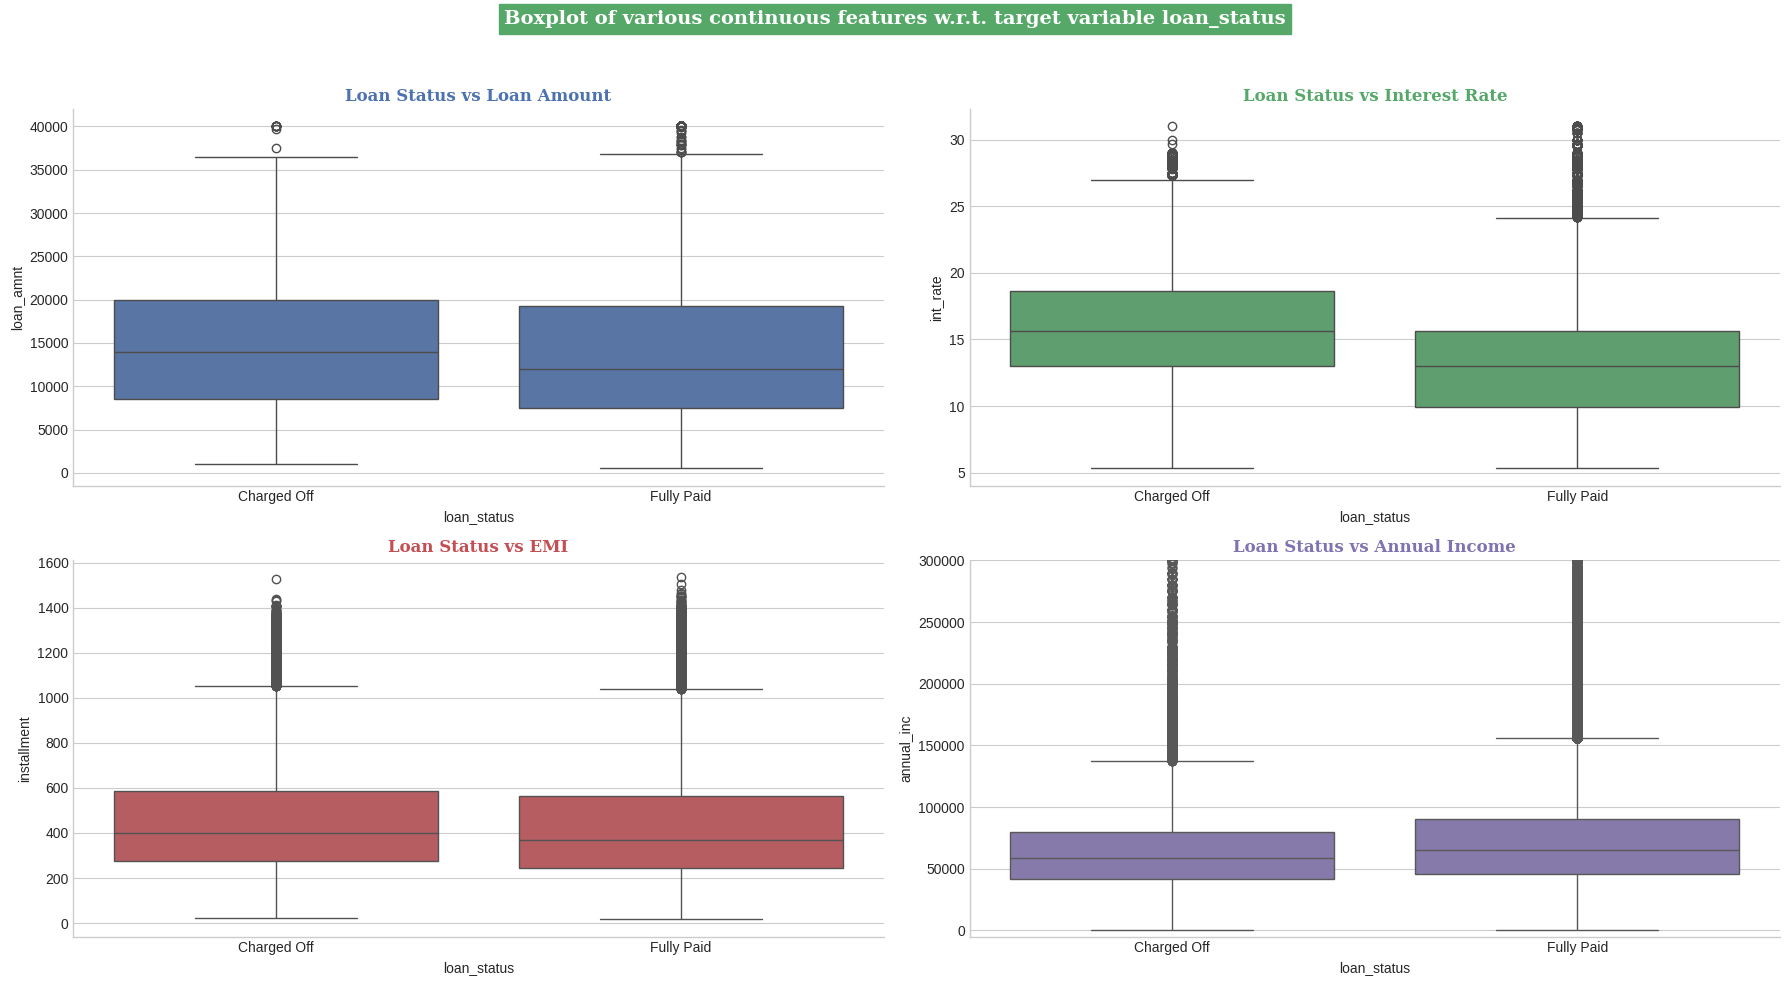

In [249]:
#Boxplot of various cont. features w.r.t. target variable loan_status

cp = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

plt.style.use('default')
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(18,10))
plt.suptitle(
    'Boxplot of various continuous features w.r.t. target variable loan_status',
    fontsize=14, fontfamily='serif', fontweight='bold',
    backgroundcolor=cp[1], color='white'
)

# 1️⃣ Loan amount
plt.subplot(221)
sns.boxplot(data=df, x='loan_status', y='loan_amnt', palette=[cp[0]])
plt.title('Loan Status vs Loan Amount', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[0])

# 2️⃣ Interest rate
plt.subplot(222)
sns.boxplot(data=df, x='loan_status', y='int_rate', palette=[cp[1]])
plt.title('Loan Status vs Interest Rate', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[1])

# 3️⃣ Installment
plt.subplot(223)
sns.boxplot(data=df, x='loan_status', y='installment', palette=[cp[2]])
plt.title('Loan Status vs EMI', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[2])

# 4️⃣ Annual Income
plt.subplot(224)
sns.boxplot(data=df, x='loan_status', y='annual_inc', palette=[cp[3]])
plt.ylim(bottom=-5000, top=300000)
plt.title('Loan Status vs Annual Income', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[3])

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Observations:

- Charged Off customers exhibit a notably higher median interest rate compared to Fully Paid customers.
- The median annual income of Charged Off customers is lower than that of Fully Paid customers.
- Charged Off customers tend to have a higher median EMI compared to Fully Paid customers.
- The median loan amount for Charged Off customers surpasses that of Fully Paid customers.

In [184]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
184308,35000.0,36,10.15,1131.82,B,B2,AGENT,MORTGAGE,180000.0,Not Verified,...,INDIVIDUAL,1,0,Jun,2014,Aug,2001,NV,22690,7


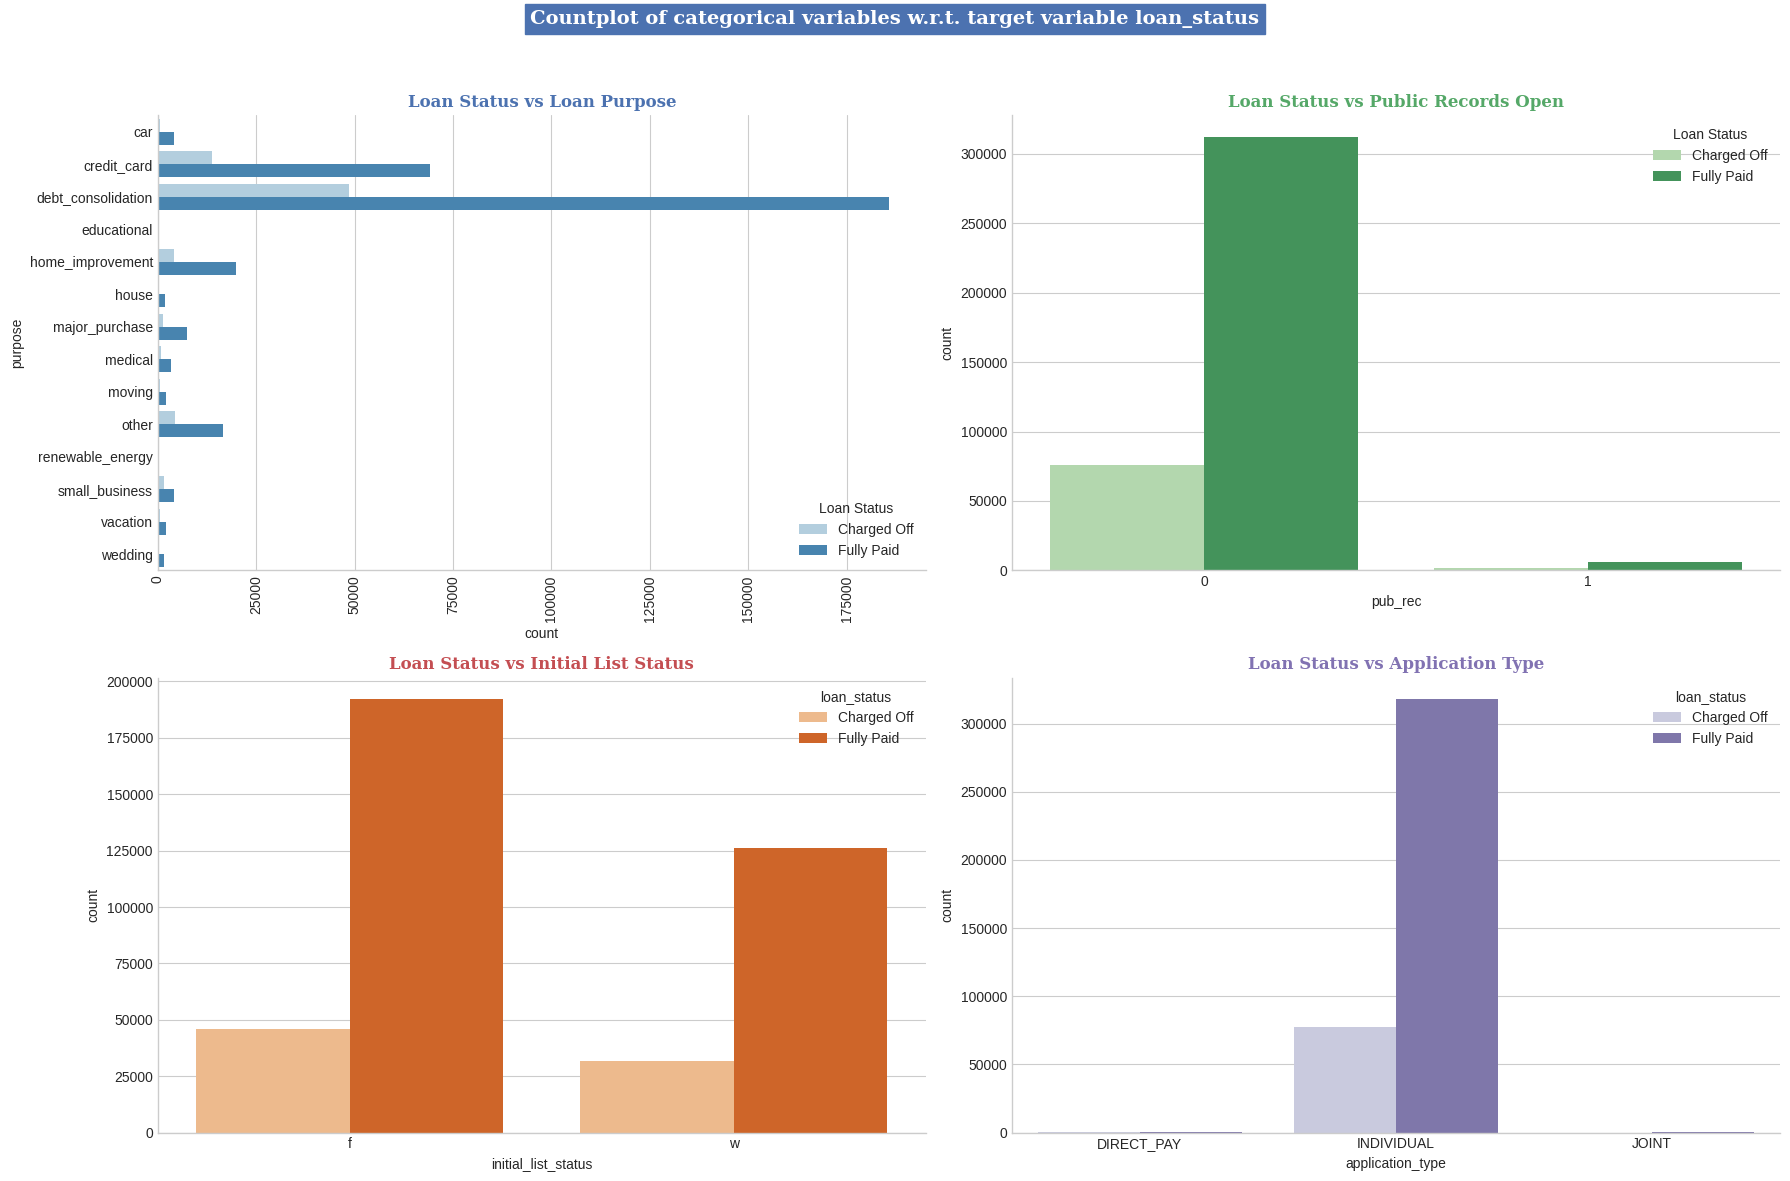

In [250]:
#Countplot of categorical variables w.r.t. target variable loan_status

cp = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

plt.style.use('default')
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(18,12))
plt.suptitle(
    'Countplot of categorical variables w.r.t. target variable loan_status',
    fontsize=14, fontfamily='serif', fontweight='bold',
    backgroundcolor=cp[0], color='white'
)

# 1️⃣ Purpose vs Loan Status
plt.subplot(221)
sns.countplot(data=df, y='purpose', hue='loan_status', palette='Blues')
plt.xticks(rotation=90)
plt.title('Loan Status vs Loan Purpose', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[0])
plt.legend(title='Loan Status', loc='lower right')

# 2️⃣ Public Records vs Loan Status
plt.subplot(222)
sns.countplot(data=df, x='pub_rec', hue='loan_status', palette='Greens')
plt.title('Loan Status vs Public Records Open', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[1])
plt.legend(title='Loan Status', loc='upper right')

# 3️⃣ Initial List Status
plt.subplot(223)
sns.countplot(data=df, x='initial_list_status', hue='loan_status', palette='Oranges')
plt.title('Loan Status vs Initial List Status', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[2])

# 4️⃣ Application Type
plt.subplot(224)
sns.countplot(data=df, x='application_type', hue='loan_status', palette='Purples')
plt.title('Loan Status vs Application Type', fontsize=12, fontfamily='serif',
          fontweight='bold', color=cp[3])

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


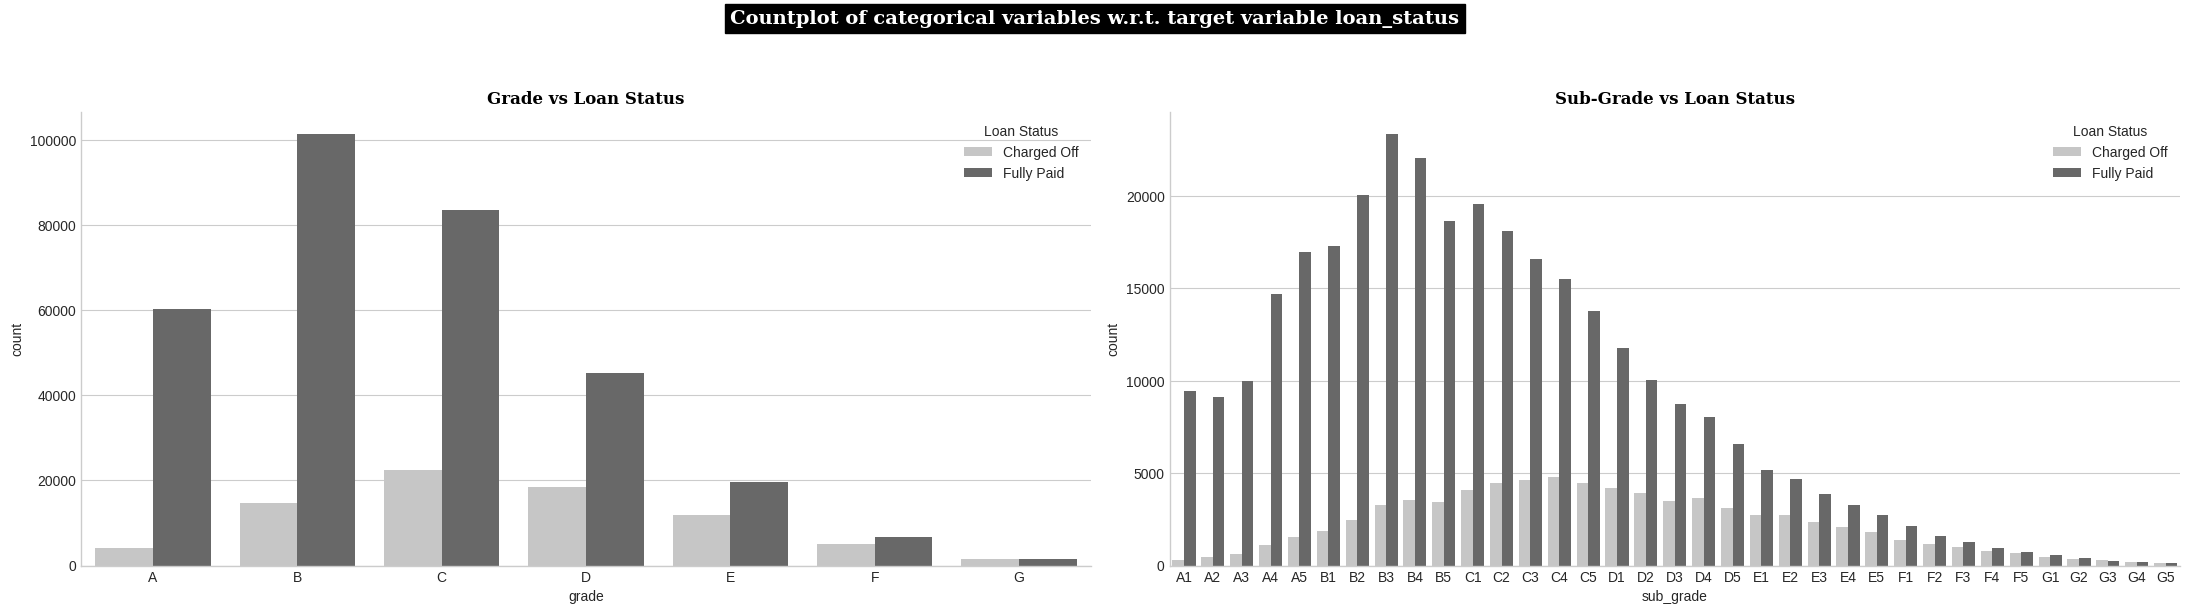

In [253]:
plt.style.use('seaborn-v0_8-whitegrid')

# Black and white palette
cp = ['#000000', '#555555', '#AAAAAA', '#DDDDDD']

plt.figure(figsize=(22,11))
plt.suptitle(
    'Countplot of categorical variables w.r.t. target variable loan_status',
    fontsize=14, fontfamily='serif', fontweight='bold',
    backgroundcolor='black', color='white'
)

# 1️⃣ Grade vs Loan Status
plt.subplot(221)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade, palette='Greys')
plt.title('Grade vs Loan Status', fontsize=12, fontfamily='serif',
          fontweight='bold', color='black')
plt.legend(title='Loan Status', loc='upper right', facecolor='white', edgecolor='black')

# 2️⃣ Sub-grade vs Loan Status
plt.subplot(222)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade, palette='Greys')
plt.title('Sub-Grade vs Loan Status', fontsize=12, fontfamily='serif',
          fontweight='bold', color='black')
plt.legend(title='Loan Status', loc='upper right', facecolor='white', edgecolor='black')

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Observations:
- Top 2 loan purpose categories are Debit Consolidation and Credit Card
- Topmost loan type application is INDIVIDUAL
- The distribution of open_acc appears to be relatively normal when visualized graphically.
- Charged Off and Fully Paid categories exhibit similar distributions.

In [187]:
df.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
240416,30225.0,36,15.8,1059.64,C,C3,National Louis University,MORTGAGE,80000.0,Verified,...,INDIVIDUAL,1,0,May,2013,Apr,2001,MI,00813,2


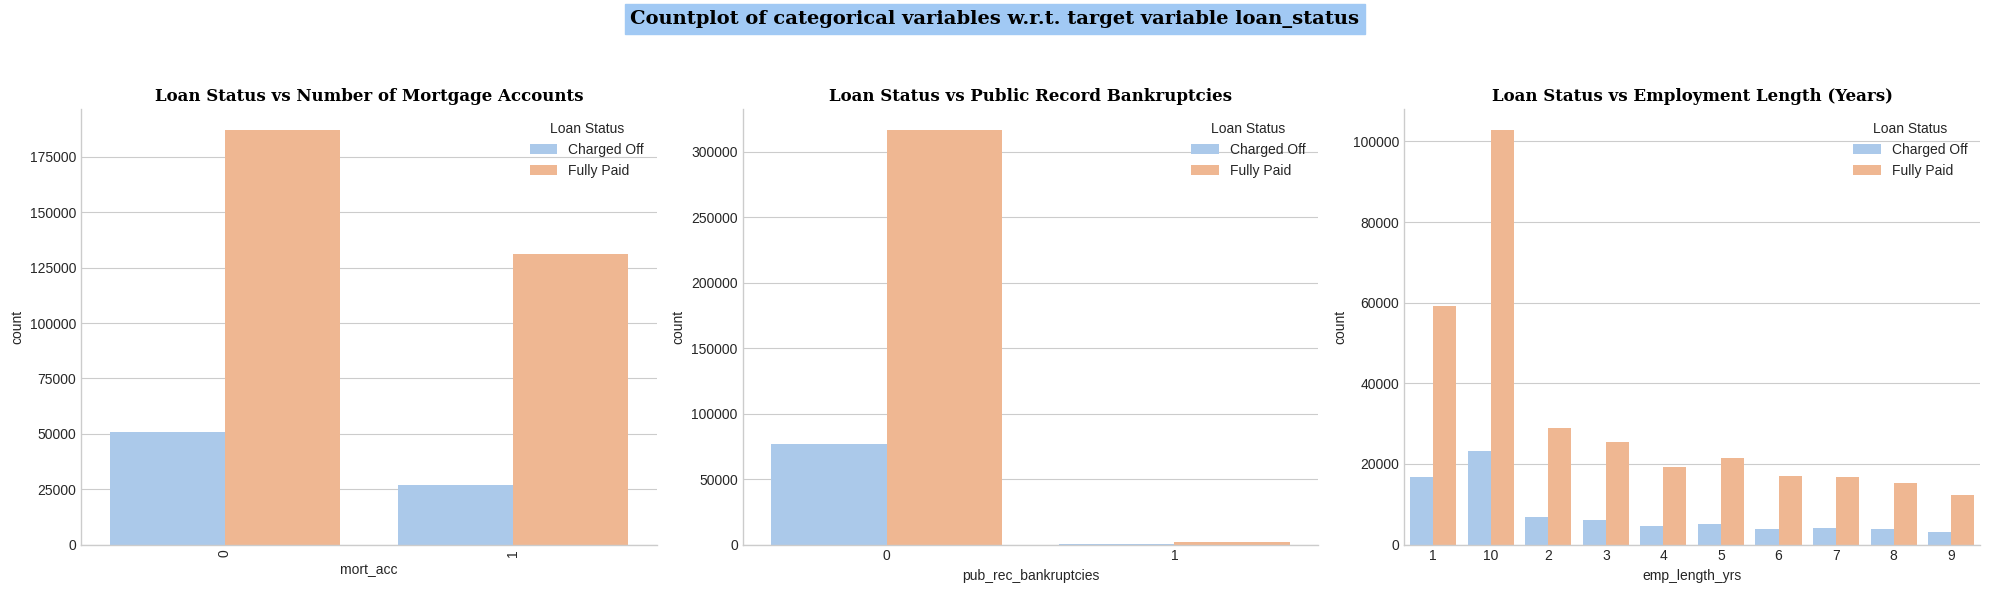

In [254]:
#Countplot for various categorical features w.r.t. target variable loan_status
# Use a subtle whitegrid style
plt.style.use('seaborn-v0_8-whitegrid')

# Soft pastel palette (faint and classy)
cp = sns.color_palette("pastel")

plt.figure(figsize=(20,6))
plt.suptitle(
    'Countplot of categorical variables w.r.t. target variable loan_status',
    fontsize=14, fontfamily='serif', fontweight='bold',
    backgroundcolor=cp[0], color='black'
)

# 1️⃣ Mortgage Accounts
plt.subplot(131)
sns.countplot(data=df, x='mort_acc', hue='loan_status', palette=cp)
plt.xticks(rotation=90)
plt.title('Loan Status vs Number of Mortgage Accounts',
          fontsize=12, fontfamily='serif', fontweight='bold', color='black')
plt.legend(title='Loan Status', loc='upper right', facecolor='white', edgecolor='black')

# 2️⃣ Public Record Bankruptcies
plt.subplot(132)
sns.countplot(data=df, x='pub_rec_bankruptcies', hue='loan_status', palette=cp)
plt.title('Loan Status vs Public Record Bankruptcies',
          fontsize=12, fontfamily='serif', fontweight='bold', color='black')
plt.legend(title='Loan Status', loc='upper right', facecolor='white', edgecolor='black')

# 3️⃣ Employment Length
plt.subplot(133)
order = sorted(df.emp_length_yrs.unique().tolist())
sns.countplot(data=df, x='emp_length_yrs', hue='loan_status', order=order, palette=cp)
plt.title('Loan Status vs Employment Length (Years)',
          fontsize=12, fontfamily='serif', fontweight='bold', color='black')
plt.legend(title='Loan Status', loc='upper right', facecolor='white', edgecolor='black')

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Q2. Comment about the correlation between Loan Amount and Installment features.

In [189]:
df[['loan_amnt', 'installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.953929
installment,0.953929,1.000000


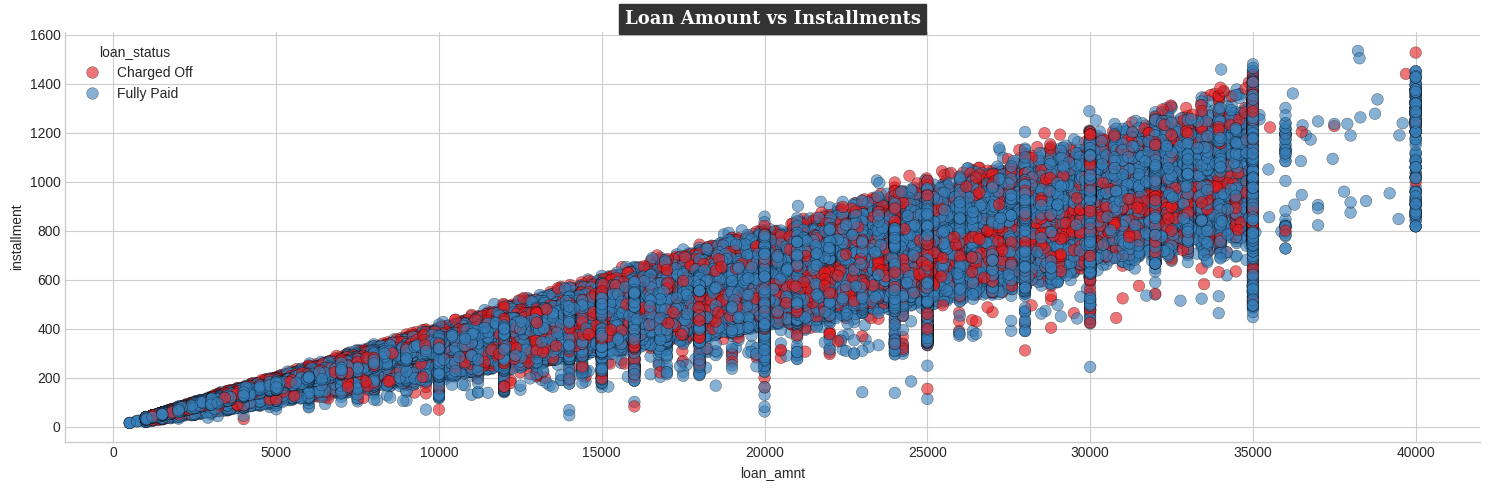

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean, bright style
plt.style.use('seaborn-v0_8-whitegrid')

# High-contrast, elegant palette (distinct but not harsh)
cp = sns.color_palette("Set1")  # vivid & clear colors

plt.figure(figsize=(15,5))
sns.scatterplot(
    data=df,
    x='loan_amnt',
    y='installment',
    alpha=0.6,                 # slightly less transparent
    hue='loan_status',
    palette=cp,
    s=70,                      # bigger points for visibility
    edgecolor='black',         # thin outline makes them pop
    linewidth=0.3
)

plt.title(
    'Loan Amount vs Installments',
    fontsize=13, fontfamily='serif', fontweight='bold',
    backgroundcolor='#333333', color='white'
)
sns.despine()
plt.tight_layout()
plt.show()


#### Insights:

The correlation coefficient measures the strength and direction of the linear relationship between two variables. In this case, the correlation coefficient between 'loan_amnt' and 'installment' is quite high, approximately 0.95, indicating a strong positive linear relationship between these two variables.

- **Loan Terms**: Understanding the relationship between loan amount and installment payments is crucial for setting appropriate loan terms. Lenders can adjust loan terms such as interest rates and repayment periods based on the borrower's ability to handle installment payments associated with different loan amounts.

- **Potential Multicollinearity**: When building predictive models, it's essential to be cautious of multicollinearity between highly correlated predictor variables. Multicollinearity can lead to unstable estimates and difficulties in interpreting the model coefficients. Therefore, it might be necessary to address multicollinearity through techniques such as variable selection or regularization.

## Q3. The majority of people have home ownership as _______.

In [191]:
(df['home_ownership'].value_counts(normalize=True)*100).to_frame()

,proportion
home_ownership,
MORTGAGE,50.084085
RENT,40.347953
OWN,9.531096
OTHER,0.028281
NONE,0.007828
ANY,0.000758


#### Insights:
- Mortgage holders comprise the majority with approximately `50.08%`, indicating that a significant portion of individuals own homes through `Mortgage` agreements.
- `Renters` constitute a substantial portion, accounting for around `40.35%` of home ownership types. This suggests a sizable demographic of individuals who opt for renting rather than owning a home.

## Q4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

In [192]:
pd.crosstab(df['grade'],df['loan_status'], normalize = 'index')

loan_status,Charged Off,Fully Paid
grade,,
A,0.062879,0.937121
B,0.125730,0.874270
C,0.211809,0.788191
D,0.288678,0.711322
E,0.373634,0.626366
F,0.427880,0.572120
G,0.478389,0.521611


#### Insights:
> **Grade 'A' borrowers demonstrate a significantly high likelihood of fully repaying their loans, with approximately 93.71% of loans being fully paid**. This suggests that borrowers with the highest credit rating are more inclined to fulfill their loan obligations successfully.
- The proportion of charged-off loans for grade 'A' borrowers is relatively low, standing at approximately 6.29%. This indicates a low default rate among borrowers with the highest credit rating, emphasizing their creditworthiness and reliability in loan repayment.

## Q5. Name the top 2 afforded job titles.

In [193]:
df[df['emp_title'] != 'No Employee Title']['emp_title'].value_counts().to_frame().head()

,count
emp_title,
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830


In [194]:
df.groupby('emp_title')['loan_status'].count().sort_values(ascending=False).to_frame()[1:6]

,loan_status
emp_title,
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830


#### Insights:

- The Most afforded job titles are `Teachers & Managers`.

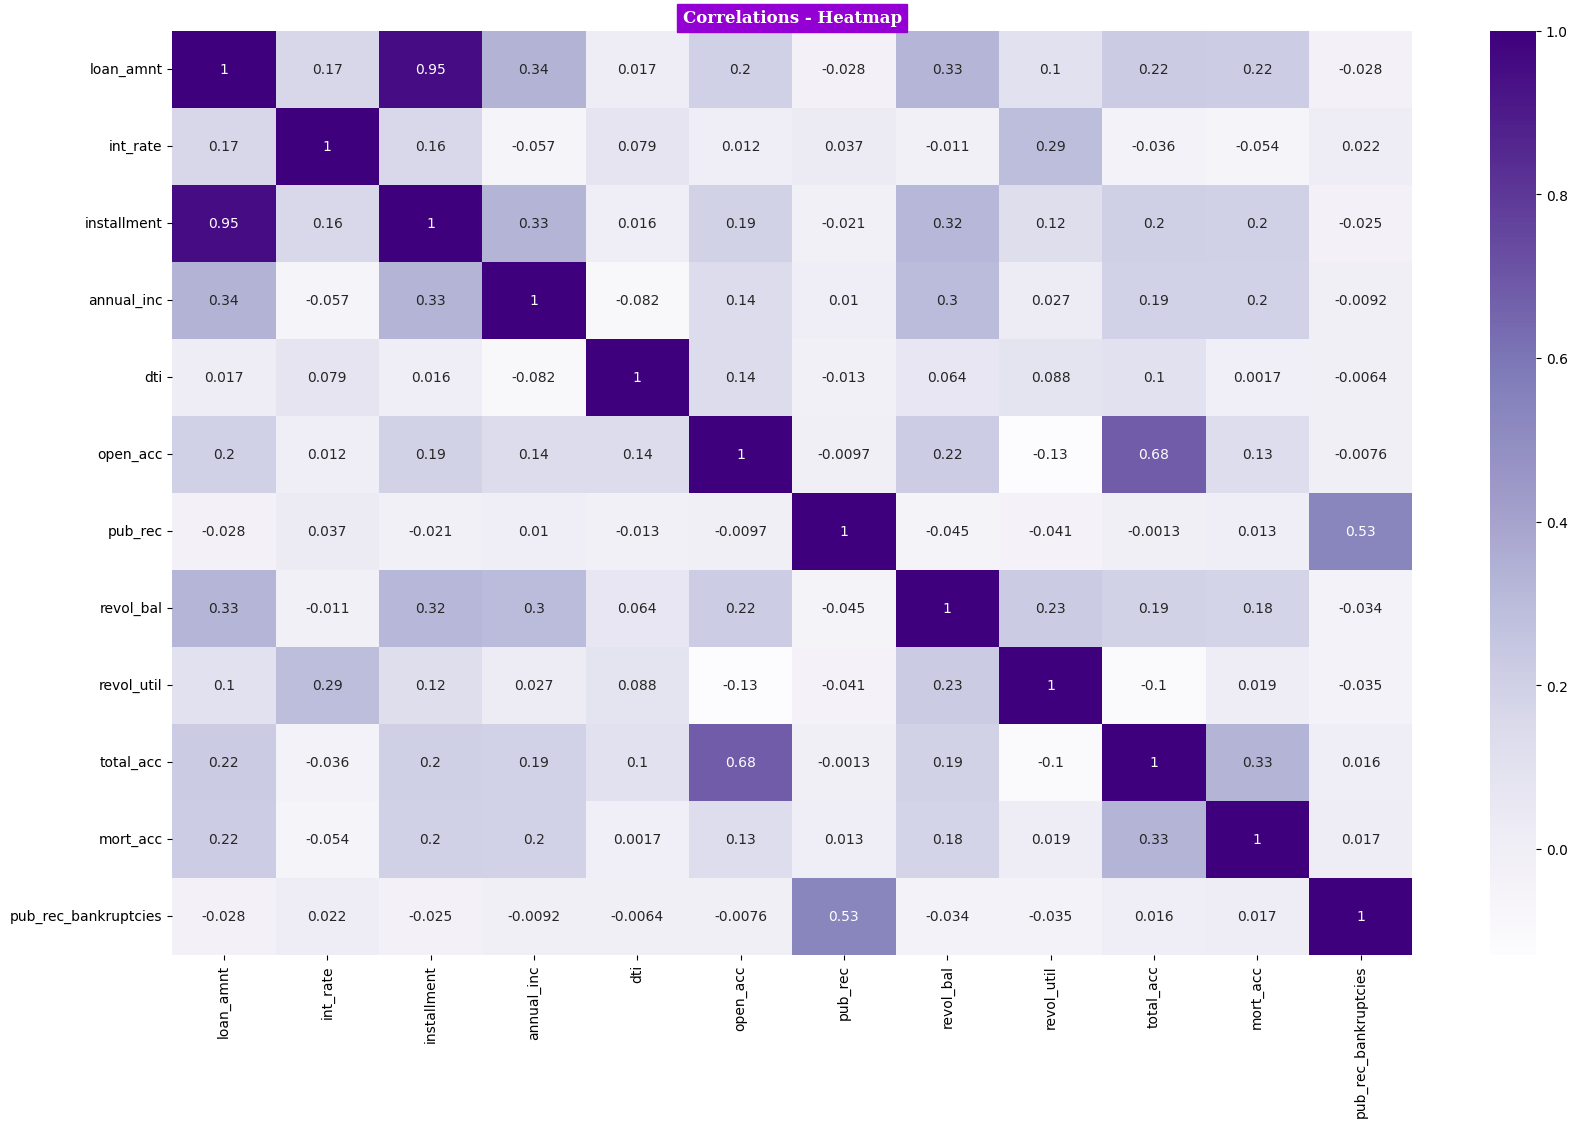

In [195]:
plt.figure(figsize=(20,12))
sns.heatmap(num_cols.corr(), annot=True, cmap='Purples')
plt.title('Correlations - Heatmap',fontsize=12,fontfamily='serif',fontweight='bold',backgroundcolor=cp[2],color='w')
plt.show()

### Observations:
- There exists a strong correlation between loan_amnt and installment, indicating that higher loan amounts correspond to larger installment payments.
- The variables total_acc and open_acc exhibit a significant correlation.
- There is a notable correlation between pub_rec_bankruptcies and pub_rec.

### Outlier Treatment:

In [196]:
numerical_cols = df.select_dtypes(include=np.number).columns
numerical_cols

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [197]:
# outlier treatment
def remove_outliers_zscore(df, threshold=2): #(considering 2 std.dev away from mean approx 95% of data)
    """
    Remove outliers from a DataFrame using the Z-score method.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The Z-score threshold for identifying outliers.
                           Observations with a Z-score greater than this threshold
                           will be considered as outliers.

    Returns:
        DataFrame: The DataFrame with outliers removed.
    """
    # Calculate Z-scores for numerical columns
    z_scores = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

    # Identify outliers
    outliers = np.abs(z_scores) > threshold

    # Keep non-outliers for numerical columns
    df_cleaned = df[~outliers.any(axis=1)]

    return df_cleaned

cleaned_df = remove_outliers_zscore(df1)
print(cleaned_df.shape)

(311392, 30)


In [198]:
def clip_outliers_zscore(df, threshold=2):
    """
    Clip outliers in a DataFrame using the Z-score method.

    Parameters:
        df (DataFrame): The input DataFrame.
        threshold (float): The Z-score threshold for identifying outliers.
                           Observations with a Z-score greater than this threshold
                           will be considered as outliers.

    Returns:
        DataFrame: The DataFrame with outliers clipped.
    """
    # Calculate Z-scores for numerical columns
    z_scores = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

    # Clip outliers
    clipped_values = df[numerical_cols].clip(df[numerical_cols].mean() - threshold * df[numerical_cols].std(),
                                             df[numerical_cols].mean() + threshold * df[numerical_cols].std(),
                                             axis=1)

    # Assign clipped values to original DataFrame
    df_clipped = df.copy()
    df_clipped[numerical_cols] = clipped_values

    return df_clipped

clipped_df = clip_outliers_zscore(df1)
print(clipped_df.shape)

(396030, 30)


In [199]:
data = cleaned_df.copy()
cp_data = clipped_df.copy()
data.sample()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
355656,6000.0,36,17.57,215.63,D,D2,No Employee Title,MORTGAGE,60600.0,Source Verified,...,INDIVIDUAL,1,0,May,2014,May,1989,MN,29597,1


In [200]:
data['pub_rec_bankruptcies'].value_counts() , data['pub_rec'].value_counts()

(pub_rec_bankruptcies
 0    311392
 Name: count, dtype: int64,
 pub_rec
 0    311392
 Name: count, dtype: int64)

In [201]:
cp_data['pub_rec_bankruptcies'].value_counts() , cp_data['pub_rec'].value_counts()

(pub_rec_bankruptcies
 0.000000    393705
 0.158662      2325
 Name: count, dtype: int64,
 pub_rec
 0.000000    388011
 0.301947      8019
 Name: count, dtype: int64)

In [202]:
data.shape

(311392, 30)

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311392 entries, 0 to 396029
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   loan_amnt             311392 non-null  float64 
 1   term                  311392 non-null  object  
 2   int_rate              311392 non-null  float64 
 3   installment           311392 non-null  float64 
 4   grade                 311392 non-null  category
 5   sub_grade             311392 non-null  category
 6   emp_title             311392 non-null  object  
 7   home_ownership        311392 non-null  category
 8   annual_inc            311392 non-null  float64 
 9   verification_status   311392 non-null  category
 10  loan_status           311392 non-null  category
 11  purpose               311392 non-null  category
 12  title                 311392 non-null  object  
 13  dti                   311392 non-null  float64 
 14  open_acc              311392 non-null  fl

#### Manual encoding:

In [204]:
data['loan_status']=data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

data['initial_list_status']=data.initial_list_status.map({'w':0, 'f':1})

In [205]:
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,...,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,er_cr_line_m,er_cr_line_y,state,zipcode,emp_length_yrs
0,10000.0,36,11.44,329.48,B,B4,Marketing,RENT,117000.0,Not Verified,...,INDIVIDUAL,0,0,Jan,2015,Jun,1990,OK,22690,10
1,8000.0,36,11.99,265.68,B,B5,Credit analyst,MORTGAGE,65000.0,Not Verified,...,INDIVIDUAL,1,0,Jan,2015,Jul,2004,SD,05113,4
2,15600.0,36,10.49,506.97,B,B3,Statistician,RENT,43057.0,Source Verified,...,INDIVIDUAL,0,0,Jan,2015,Aug,2007,WV,05113,1
3,7200.0,36,6.49,220.65,A,A2,Client Advocate,RENT,54000.0,Not Verified,...,INDIVIDUAL,0,0,Nov,2014,Sep,2006,MA,00813,6
4,24375.0,60,17.27,609.33,C,C5,Destiny Management Inc.,MORTGAGE,55000.0,Verified,...,INDIVIDUAL,0,0,Apr,2013,Mar,1999,VA,11650,9


### Feature selection - done by hypothesis testing & VIF(multicolinearity)

> Find VIF after modelling and remove features with high VIF (>5):

```python
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif
```

In [206]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[col], data['loan_status']))
    if p > 0.05:
        print('>>>>>>> Independent feature - Not Significant:',col,' >> p value:',p)

>>>>>>> Independent feature - Not Significant: emp_title  >> p value: 0.5367121560200798
>>>>>>> Independent feature - Not Significant: title  >> p value: 1.0
>>>>>>> Independent feature - Not Significant: er_cr_line_m  >> p value: 0.2722117086158036
>>>>>>> Independent feature - Not Significant: state  >> p value: 0.76047808977373


In [207]:
## dropping cols based on correlation(heatmap,hypothesis testing)
lt = data.drop(columns=['emp_title','title','sub_grade','er_cr_line_m','er_cr_line_y','initial_list_status',
                        'state','issue_month','issue_year','pub_rec','pub_rec_bankruptcies'],axis=1)
lt.shape

(311392, 19)

In [208]:
lt.sample()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,zipcode,emp_length_yrs
145315,10625.0,36,10.99,347.8,B,RENT,32500.0,Not Verified,1,credit_card,27.03,20.0,9293.0,22.3,32.0,INDIVIDUAL,0,48052,6


In [209]:
#### Performing OneHotEncoding on feature having multiple variable
dummies=['zipcode', 'grade','purpose','home_ownership','verification_status','application_type']
ltd = pd.get_dummies(lt, columns=dummies, drop_first=True)

In [210]:
ltd.shape

(311392, 50)

In [211]:
ltd.sample(8)

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,open_acc,revol_bal,revol_util,...,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
92145,15000.0,36,14.33,515.08,42000.0,0,15.00,8.0,6652.0,67.2,...,False,False,False,False,False,True,True,False,True,False
1726,25000.0,60,15.22,597.64,75500.0,1,33.10,15.0,29375.0,64.7,...,False,True,False,False,False,False,False,True,True,False
290657,6000.0,36,5.32,180.69,41175.0,1,4.14,4.0,5419.0,36.6,...,False,True,False,False,False,False,False,True,True,False
312003,20000.0,60,21.49,546.60,45128.0,1,14.31,8.0,10986.0,80.8,...,False,False,False,False,True,False,False,True,True,False
144406,29000.0,60,14.31,679.45,75000.0,1,14.30,6.0,28540.0,76.5,...,False,False,False,False,False,True,True,False,True,False
101839,4500.0,36,19.05,165.07,16000.0,1,31.28,8.0,9533.0,77.5,...,False,True,False,False,False,False,False,True,True,False
82578,10000.0,36,7.62,311.62,33000.0,1,3.53,5.0,2841.0,41.8,...,False,True,False,False,False,False,False,False,True,False
150268,23450.0,60,20.99,634.27,63000.0,0,23.92,12.0,15987.0,68.6,...,False,True,False,False,False,False,False,True,True,False


#### Model:

In [212]:
#Prepare X and y dataset i.e. independent and dependent datasets

X = ltd.drop(['loan_status'], axis=1)
y = ltd['loan_status']

In [213]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(249113, 49)
(62279, 49)
(249113,)
(62279,)


#### Minmax scaling the data

In [214]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [215]:
X_train.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,...,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
0,0.379538,0.0,0.339161,0.411590,0.207250,0.465341,0.368421,0.171897,0.419816,0.276596,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.643564,1.0,0.680070,0.524221,0.367868,0.252652,0.473684,0.221905,0.590398,0.340426,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.168317,0.0,0.208625,0.176198,0.134712,0.357576,0.368421,0.052236,0.304392,0.212766,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.379538,1.0,0.680070,0.307444,0.367868,0.449242,0.315789,0.255109,0.767109,0.297872,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.368812,0.0,0.543706,0.421460,0.246109,0.315530,0.263158,0.090649,0.614913,0.361702,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 🏷️**Model-1**

In [216]:
#Fit the Model on training data
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [217]:
#Predit the data on test dataset
y_train_pred = logreg_model.predict(X_train)
y_test_pred = logreg_model.predict(X_test)

In [218]:
logreg_model.score(X_test, y_test) , logreg_model.score(X_test, y_test_pred)

(0.8934793429566948, 1.0)

If logreg_model.score(X_test, y_test) consistently returns 1, it would imply that your model is predicting the test set perfectly, which could be a sign of overfitting, data leakage, or an issue with the evaluation process.

Train Accuracy : 0.89
Train F1 Score: 0.94
Train Recall Score: 1.0
Train Precision Score: 0.89

Test Accuracy : 0.89
Test F1 Score: 0.94
Test Recall Score: 1.0
Test Precision Score: 0.89


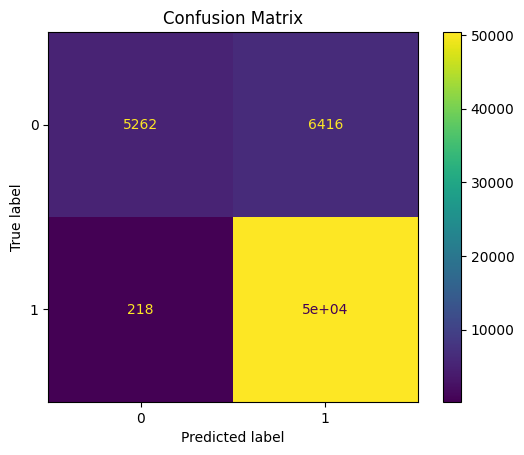

In [219]:
#Model Evaluation
print('Train Accuracy :', round(logreg_model.score(X_train, y_train), 2))
print('Train F1 Score:', round(f1_score(y_train, y_train_pred), 2))
print('Train Recall Score:', round(recall_score(y_train, y_train_pred), 2))
print('Train Precision Score:', round(precision_score(y_train, y_train_pred), 2))

print('\nTest Accuracy :', round(logreg_model.score(X_test, y_test), 2))
print('Test F1 Score:', round(f1_score(y_test, y_test_pred), 2))
print('Test Recall Score:', round(recall_score(y_test, y_test_pred), 2))
print('Test Precision Score:', round(precision_score(y_test, y_test_pred), 2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [220]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61     11678
           1       0.89      1.00      0.94     50601

    accuracy                           0.89     62279
   macro avg       0.92      0.72      0.78     62279
weighted avg       0.90      0.89      0.88     62279



* Here the recall value for the 'charged off' is very low, Hence will build a better model

#### **Model-2**

In [221]:
# Oversampling to balance the target variable

sm=SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

print(f"Before OverSampling, count of label 1: {sum(y_train == 1)}")
print(f"Before OverSampling, count of label 0: {sum(y_train == 0)}")
print(f"After OverSampling, count of label 1: {sum(y_train_res == 1)}")
print(f"After OverSampling, count of label 0: {sum(y_train_res == 0)}")

Before OverSampling, count of label 1: 202401
Before OverSampling, count of label 0: 46712
After OverSampling, count of label 1: 202401
After OverSampling, count of label 0: 202401


Train Accuracy : 0.79
Train F1 Score: 0.86
Train Recall Score: 0.79
Train Precision Score: 0.95

Test Accuracy : 0.8
Test F1 Score: 0.86
Test Recall Score: 0.79
Test Precision Score: 0.95


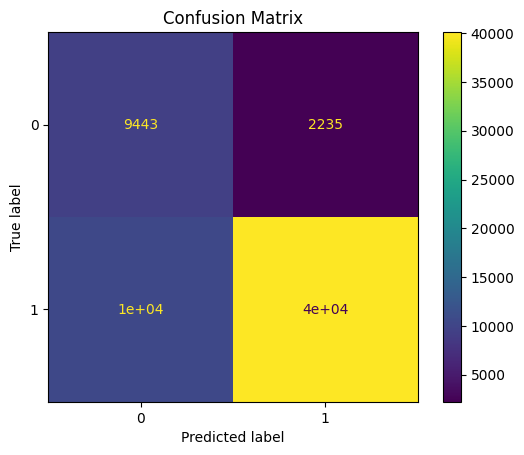

In [222]:
model = LogisticRegression()
model.fit(X_train_res, y_train_res)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

#Model Evaluation
print('Train Accuracy :', round(model.score(X_train, y_train), 2))
print('Train F1 Score:', round(f1_score(y_train, train_preds), 2))
print('Train Recall Score:', round(recall_score(y_train, train_preds), 2))
print('Train Precision Score:', round(precision_score(y_train, train_preds), 2))

print('\nTest Accuracy :', round(model.score(X_test, y_test), 2))
print('Test F1 Score:', round(f1_score(y_test, test_preds), 2))
print('Test Recall Score:', round(recall_score(y_test, test_preds), 2))
print('Test Precision Score:', round(precision_score(y_test, test_preds), 2))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [223]:
y_pred = test_preds
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.81      0.60     11678
           1       0.95      0.79      0.86     50601

    accuracy                           0.80     62279
   macro avg       0.71      0.80      0.73     62279
weighted avg       0.86      0.80      0.81     62279



### Observations:

- The model demonstrates a high recall score, successfully identifying 80% of actual defaulters.
- However, the precision for the positive class (defaulters) is low; only 47% of predicted defaulters are actually defaulters.
- This high recall and low precision indicate that while the model is effective at flagging most defaulters, it also results in many false positives. Consequently, many deserving customers may be denied loans.
- The low precision adversely affects the F1 score, reducing it to 60%, despite an overall accuracy of 80%. This highlights the trade-off between precision and recall in the model's performance.
> Explanation :
- The model is good at catching most people who don't pay back their loans it catches 80% of them.
- But, when it says someone won't pay back, it's right only half of the time.47% So, there's a chance it's making mistakes and wrongly flagging people.
- Because of these mistakes, some people who deserve loans might not get them.
- Even though the model seems okay overall, its balance between being right and not making mistakes isn't great. It's like a seesaw; when one side goes up, the other goes down.

### 🏷️Regularization Model

In [224]:
#Try with different regularization factor lamda and choose the best to build the model

lamb = np.arange(0.01, 1000, 10)

train_scores = []
test_scores = []

for lam in lamb:
    model = LogisticRegression(C = 1/lam)
    model.fit(X_train, y_train)

    tr_score = model.score(X_train, y_train)
    te_score = model.score(X_test, y_test)

    train_scores.append(tr_score)
    test_scores.append(te_score)

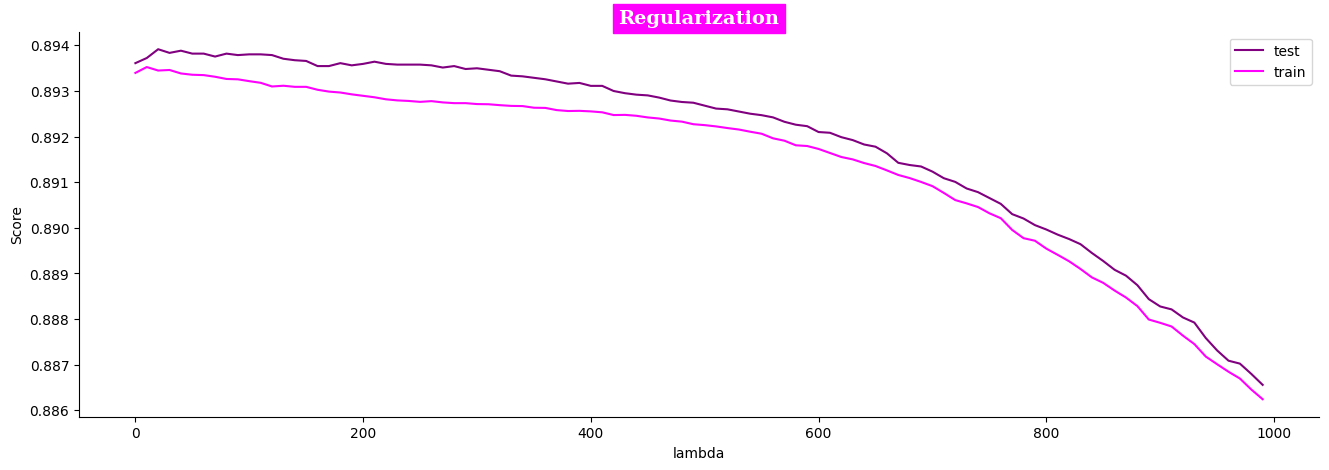

In [225]:
#Plot the train and test scores with respect lambda values i.e. regularization factors
ran = np.arange(0.01, 1000, 10)
plt.figure(figsize=(16,5))
sns.lineplot(x=ran,y=test_scores,color='purple',label='test')
sns.lineplot(x=ran,y=train_scores,color='magenta',label='train')
plt.title('Regularization',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='magenta',color='w')
plt.xlabel("lambda")
plt.ylabel("Score")
sns.despine()
plt.show()

In [226]:
#Check the index of best test score and the check the best test score

print(np.argmax(test_scores))
print(test_scores[np.argmax(test_scores)])

2
0.8939128759292859


In [227]:
#Calculate the best lambda value based on the index of best test score

best_lamb = 0.01 + (10*2)
best_lamb

20.01

In [228]:
lamdba = np.argmax(test_scores)

In [229]:
#Fit the model using best lambda

reg_model = LogisticRegression(C=1/best_lamb)
reg_model.fit(X_train, y_train)

LogisticRegression(C=0.04997501249375312)

In [230]:
#Predict the y_values and y_probability values

y_reg_pred = reg_model.predict(X_test)
y_reg_pred_proba = reg_model.predict_proba(X_test)

In [231]:
#Print model score

print(f'Logistic Regression Model Score with best lambda: ',end='')
print(round(model.score(X_test, y_test)*100,2),'%')

Logistic Regression Model Score with best lambda: 88.66 %


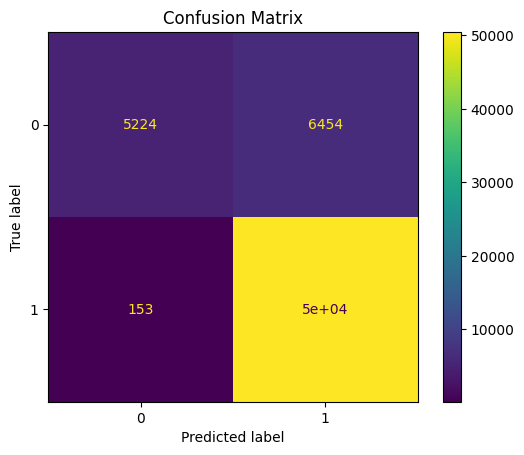

In [232]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_reg_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [233]:
print(classification_report(y_test, y_reg_pred))

              precision    recall  f1-score   support

           0       0.97      0.45      0.61     11678
           1       0.89      1.00      0.94     50601

    accuracy                           0.89     62279
   macro avg       0.93      0.72      0.78     62279
weighted avg       0.90      0.89      0.88     62279



#### 💡Observations from classification report:
> Regularized model

* `Precision : 89%`  
* `Recall : 100%`
* `F1-score : 94%`
* `Accuracy : 89%`




## 🔹**K-fold - Cross_validation**

- cross validation accuracy has to be approx 89%

In [234]:
x=scaler.fit_transform(X)

kfold = KFold(n_splits=10)
accuracy = np.mean(cross_val_score(reg_model,x,y,cv=kfold,scoring='accuracy'))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.894


In [235]:
cm = confusion_matrix(y_test, y_reg_pred)
cm_df = pd.DataFrame(cm, index=['Defaulter','Fully paid'], columns=['Defaulter','Fully paid'])
cm_df

,Defaulter,Fully paid
Defaulter,5224,6454
Fully paid,153,50448


#### Insights:

* TN = 5223 (True Negative: Correctly predicted Charged Off)
* TP = 50450 (True Positive: Correctly predicted Fully Paid)
* FP = 6455 (False Positive: Predicted Fully Paid but actually Charged Off)
* FN = 151 (False Negative: Predicted Charged Off but actually Fully Paid)
* Actual Negative (Charged Off) = 5223 + 6455 = 11678
* Actual Positive (Fully Paid) = 151 + 50450 = 50601
* Predicted Negative (Charged Off) = 5223 + 151 = 5374
* Predicted Positive (Fully Paid) = 6455 + 50450 = 56905

In [236]:
#Collect the model coefficients and print those in dataframe format
coeff_df = pd.DataFrame()
coeff_df['Features'] = X_train_res.columns
coeff_df['Weights'] = model.coef_[0]
coeff_df['ABS_Weights'] = abs(coeff_df['Weights'])
coeff_df = coeff_df.sort_values(['ABS_Weights'], ascending=False)
coeff_df

,Features,Weights,ABS_Weights
13,zipcode_11650,-2.205071,2.205071
20,zipcode_93700,-2.199511,2.199511
19,zipcode_86630,-2.187202,2.187202
12,zipcode_05113,1.349854,1.349854
15,zipcode_29597,1.345002,1.345002
2,int_rate,-0.647268,0.647268
5,dti,-0.533302,0.533302
24,grade_E,-0.464009,0.464009
4,annual_inc,0.460678,0.460678
1,term,-0.432346,0.432346


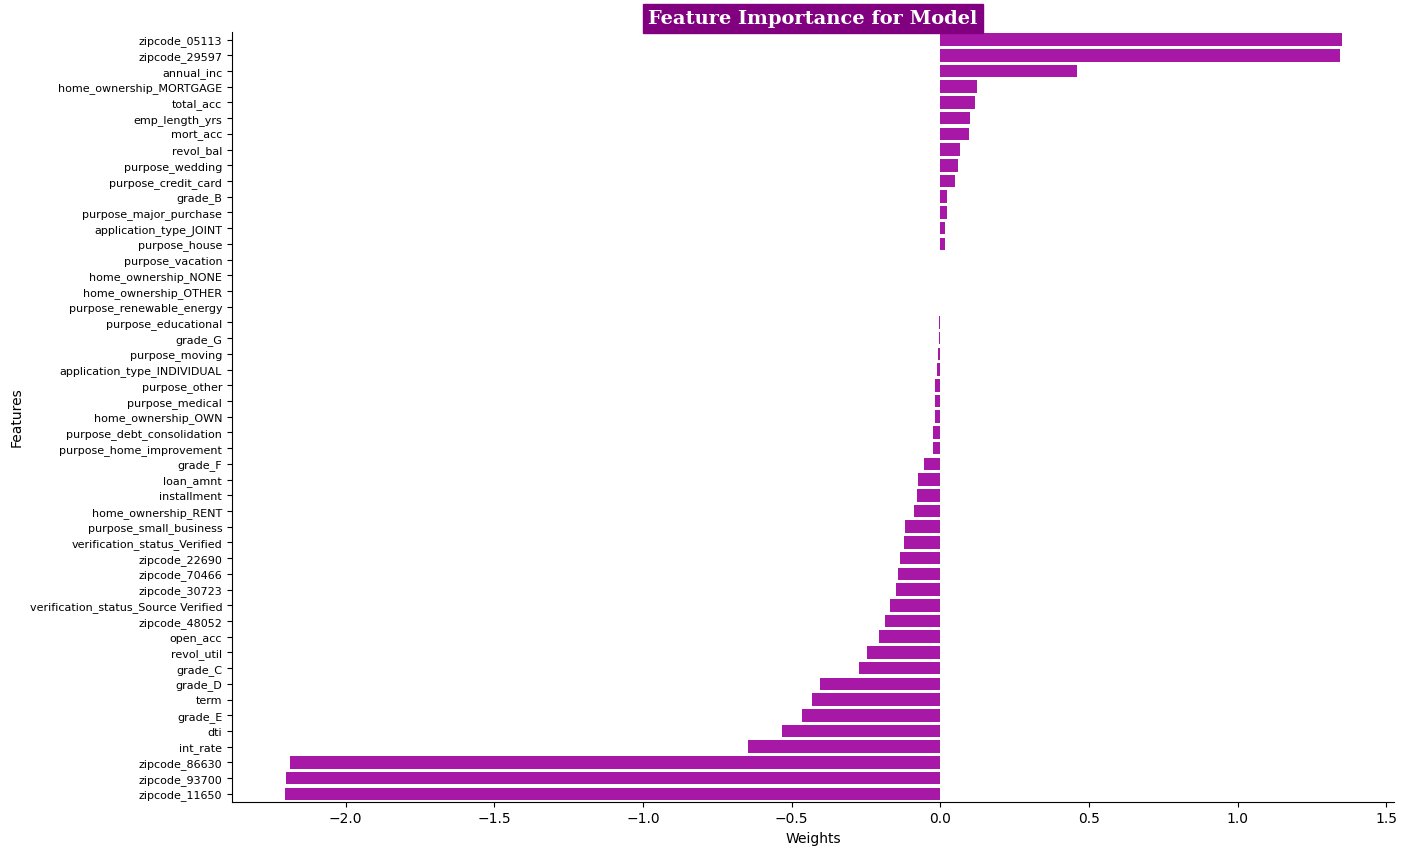

In [237]:
imp_feature = coeff_df.sort_values(by='Weights',ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(y = imp_feature['Features'],
           x = imp_feature['Weights'],color='m')
plt.title("Feature Importance for Model",fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.xlabel("Weights")
plt.yticks(fontsize=8)
plt.ylabel("Features")
sns.despine()
plt.show()

In [238]:
#Logistic Regression model intercept

model.intercept_

array([2.52298763])

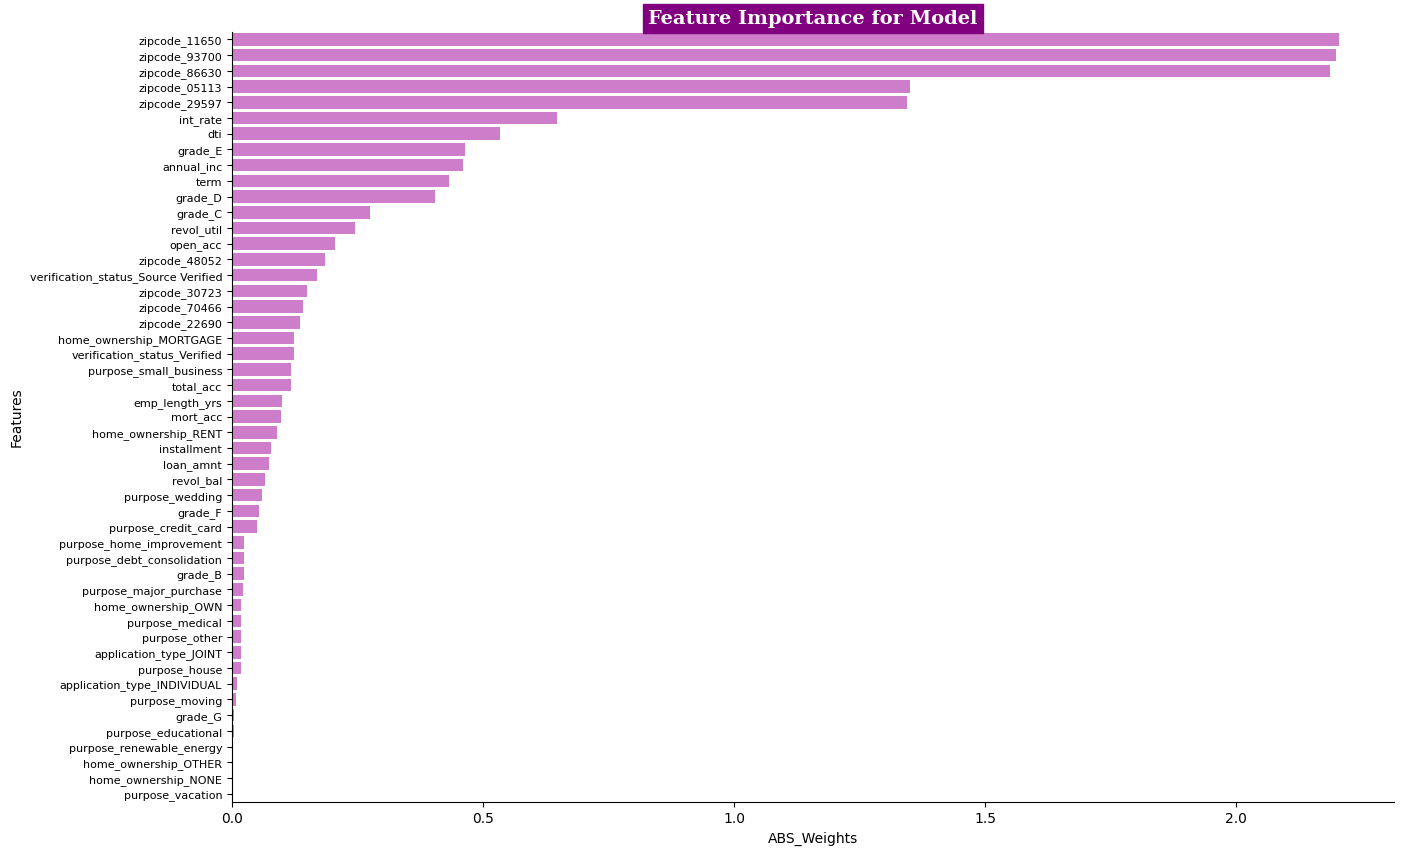

In [239]:
plt.figure(figsize=(15,10))
sns.barplot(y = coeff_df['Features'],x = coeff_df['ABS_Weights'],color='orchid')
plt.title("Feature Importance for Model",fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.xlabel("ABS_Weights")
plt.yticks(fontsize=8)
plt.ylabel("Features")
sns.despine()
plt.show()

#### Observations:

- The model has assigned significant weight to the zip_code, Annual Income, grade features, indicating that certain zip codes strongly influence the prediction of defaulters.
- Features such as dti (debt-to-income ratio), open_acc (number of open accounts), and loan_amnt (loan amount) also have high positive coefficients, highlighting their importance in predicting default risk.
- On the other hand, several zip codes have large negative coefficients, suggesting that they are associated with a lower likelihood of default.


### ROC AUC curve

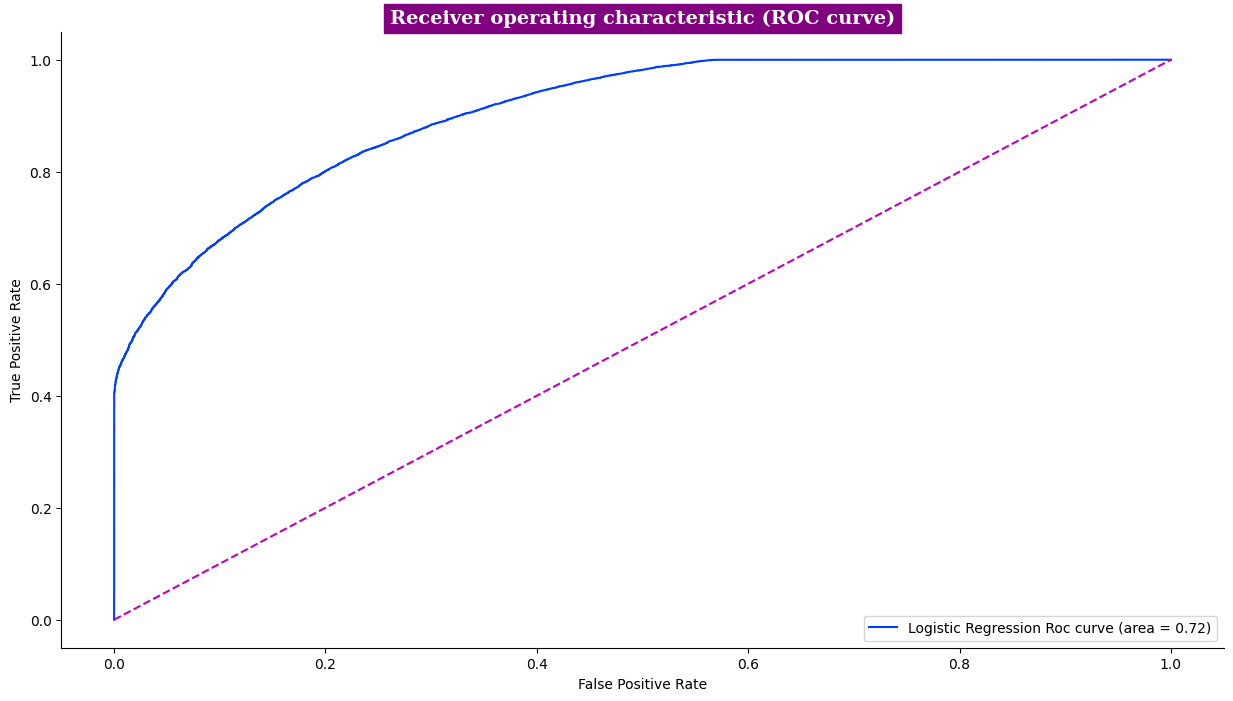

In [240]:
# area under ROC curve
logit_roc_auc = roc_auc_score(y_test,y_reg_pred)

# Compute the false positive rate, true positive rate, and thresholds
fpr,tpr,thresholds = roc_curve(y_test,y_reg_pred_proba[:,1])

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(15,8))
plt.plot(fpr,tpr,label='Logistic Regression Roc curve (area = %0.2f)'% logit_roc_auc)
plt.plot([0,1],[0,1],'m--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='purple',color='w')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [241]:
logit_roc_auc

np.float64(0.7221566085466022)

In [242]:
roc_auc = auc(fpr, tpr)
roc_auc

np.float64(0.9036968327803755)

#### Insights:

**Trade-off in Performance**: The ROC curve area, representing model performance, is 72%. This indicates that the model effectively distinguishes between classes 72% of the time.

- Ideally, we aim for a higher True Positive Rate (TPR) and a lower False Positive Rate (FPR) to ensure accurate predictions.

- The ROC curve illustrates that as True Positives increase, there's a simultaneous increase in False Positives.

- Misclassification: This trade-off implies that while identifying more Fully Paid customers, there's a heightened risk of misclassifying Charged Off customers as Fully Paid, potentially leading to Non-Performing Assets (NPAs).

These points emphasize the need to mitigate this risk:

- Reducing FPR while maintaining TPR is crucial to minimize misclassifications and associated risks.
- By shifting False Positives towards the left on the ROC curve, the model's overall performance, as measured by AUC, can improve.
- This improvement in AUC relies on maintaining a high True Positive Rate while reducing False Positives.

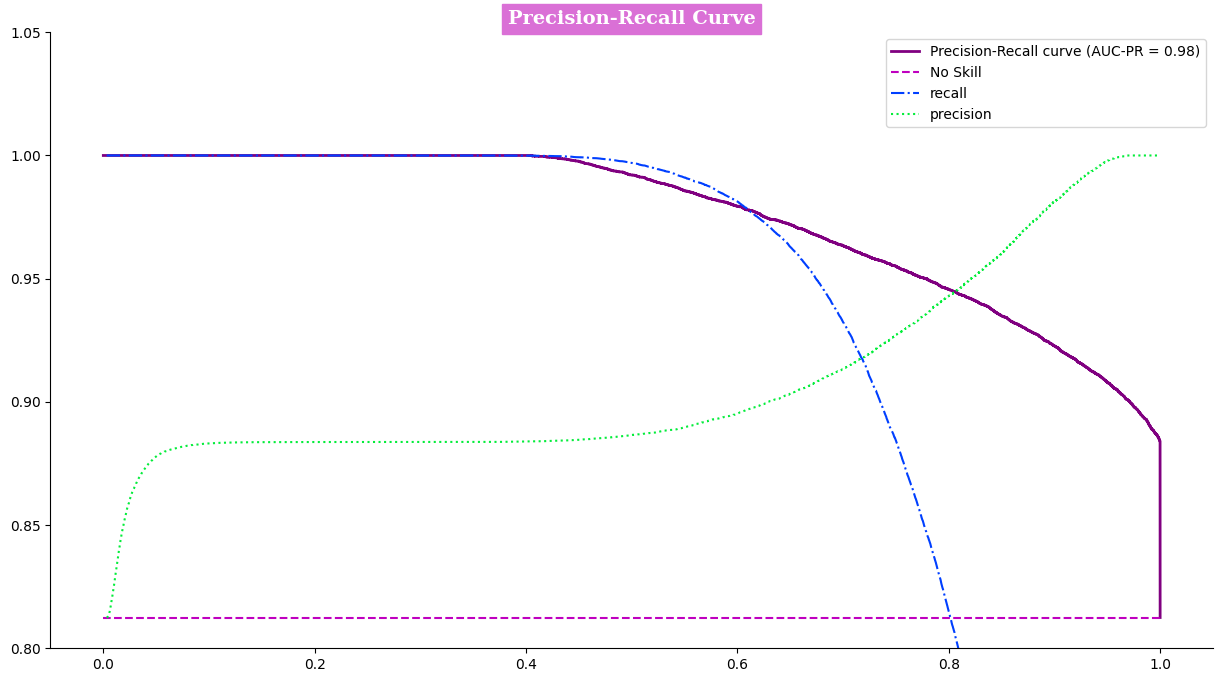

In [243]:
precision, recall, thresholds = precision_recall_curve(y_test, y_reg_pred_proba[:,1])

average_precision = average_precision_score(y_test, y_reg_pred_proba[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(15,8))
plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AUC-PR = {average_precision:.2f})')
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='m')
plt.plot(thresholds, recall[0:thresholds.shape[0]], label='recall',linestyle='-.')
plt.plot(thresholds, precision[0:thresholds.shape[0]], label='precision',linestyle='dotted')
# plt.xlim([0.0, 1.0])
plt.ylim([0.8, 1.05])
plt.title('Precision-Recall Curve',fontsize=14,fontfamily='serif',fontweight='bold',backgroundcolor='orchid',color='w')
plt.legend(loc='upper right')
sns.despine()
plt.show()

In [244]:
auc(recall, precision).round(3)

np.float64(0.975)

### Observations:
> 💡Insight:

* The Area Under the Curve (AUC) for the precision-recall curve is 0.975. This high AUC value suggests that the model achieves excellent performance in distinguishing between positive and negative classes, showcasing strong precision-recall characteristics.

- **Precision-Recall Curve Superiority**: Precision-recall curves are pivotal, especially in imbalanced datasets, focusing on accurate predictions of the relevant class (Class 1 - Fully paid in this case).

- **Irrelevance of True Negatives**: Precision and recall computations disregard true negatives, simplifying focus to the correct prediction of Fully Paid customers.

- **AUC Strengthens Model Evaluation**: A high AUC (97.5%) underscores the model's robustness in distinguishing between classes, indicating its efficacy.

- **Precision Enhancement Priority**: Optimal model refinement centers on elevating precision by minimizing False Positives, vital for improving overall performance and mitigating risks.

In [245]:
# balenced Model
lr = LogisticRegression(max_iter=1000, class_weight='balanced')

lr_model = lr.fit(X_train, y_train)

print(classification_report(y_test, lr_model.predict(X_test)))

cm_bal = confusion_matrix(y_test, lr_model.predict(X_test))
cm_bal_df = pd.DataFrame(cm_bal, index=['Defaulter','Fully paid'], columns=['Defaulter','Fully paid'])
cm_bal_df

              precision    recall  f1-score   support

           0       0.47      0.81      0.60     11678
           1       0.95      0.79      0.86     50601

    accuracy                           0.79     62279
   macro avg       0.71      0.80      0.73     62279
weighted avg       0.86      0.79      0.81     62279



,Defaulter,Fully paid
Defaulter,9468,2210
Fully paid,10586,40015


#### Observations from classification report:
> Balenced model

* `Precision : 95%`  
* `Recall : 79%`
* `F1-score : 86%`
* `Accuracy : 79%`

#### 💡Insights:

- TN = 9466 (True Negative: Correctly predicted Charged Off)
- TP = 40028 (True Positive: Correctly predicted Fully Paid)
- FP = 2212 (False Positive: Predicted Fully Paid but actually Charged Off)
- FN = 10573 (False Negative: Predicted Charged Off but actually Fully Paid)
- Actual Negative (Charged Off) = 9466 + 2212 = 11678
- Actual Positive (Fully Paid) = 10573 + 40028 = 50601
- Predicted Negative (Charged Off) = 9466 + 10573 = 20039
- Predicted Positive (Fully Paid) = 2212 + 40028 = 42240

In [246]:
lr_model.intercept_

array([6.35576692])

## Q6: Thinking from a bank's perspective, which metric should our primary focus be on..
a. ROC AUC  
b. Precision  
c. Recall  
d. F1 Score  

Ans:
> From a bank's perspective, minimizing risks and maximizing profitability are paramount. `ROC AUC (Receiver Operating Characteristic Area Under Curve)` is indeed a crucial metric because it encompasses both True Positive Rate (TPR) and False Positive Rate (FPR)

* Bank's primary focus should be on ROC AUC , because bank needs to reduce FPR (False Positive Rate) and needs to increase the TPR (True Positive Rate).

- Maximizing TPR ensures that the bank correctly identifies customers who fully pay their loans (reducing False Negatives), while minimizing FPR ensures that the bank doesn't wrongly classify customers as fully paid when they're actually charged off (reducing False Positives).

- By optimizing ROC AUC, the bank can strike a balance between correctly identifying creditworthy customers and minimizing the risk of defaulters, thereby enhancing the overall performance and reliability of its credit scoring model.

####  **Another approach**:
* since I'm having `High Recall` value of 100% in Regularized model(most efficient model:
> From a bank's perspective, the primary focus should be on minimizing risks while maximizing profitability. Therefore, the most relevant metric would be **Precision**.

- Precision represents the proportion of correctly predicted positive instances (e.g., customers who fully pay their loans) out of all instances predicted as positive. In the context of a bank, precision reflects the accuracy of identifying creditworthy customers who are likely to repay their loans. Maximizing precision ensures that the bank minimizes the number of false positives, which are instances where the bank incorrectly identifies customers as creditworthy when they are not. By prioritizing precision, the bank can reduce the risk of loan defaults and associated financial losses.

- While ROC AUC, Recall, and F1 Score are also important metrics, precision aligns closely with the bank's objective of minimizing risks and ensuring the quality of its loan portfolio.

## Q7. How does the gap in precision and recall affect the bank?

> Ans:

*   To fully understand a model’s errors, it’s important to analyze both false positives and false negatives, which are measured using metrics such as precision and recall. A low recall can be particularly risky for a bank.
*  The gap between precision and recall reflects the model’s balance — a wider gap indicates a higher rate of incorrect predictions.
* High precision implies fewer false positives, meaning the bank is less likely to classify genuine customers as defaulters (resulting in fewer NPA loan accounts).
* High recall indicates fewer false negatives, ensuring the bank doesn’t miss out on good customers who are actually creditworthy.


## Q8. Which were the features that heavily affected the outcome?

> Ans:

- `Address(Zipcode), Annual_Income, Grade`  seems to be most important feature in our case.

- Loan duration `term`, Total Credit balance `revol_bal`, : Monthly debt vs. monthly income ratio `dti`, Interest `int_rate` also has high weights(coeffients) in the model .


## Q9. Will the results be affected by geographical location? (Yes/No)

> Ans:
- Yes,  we can see that zip_code (Address) is a very important feature so geographical location has impact on our result.

------

## <span style="color:darkorchid"><strong>Business Recommendations for LoanTap</strong></span>


> <span style="color:magenta"><strong>Optimize Loan Approval Strategy:</strong></span>
   - Focus on maximizing the F1 score and area under the Precision-Recall Curve to effectively manage the precision-recall trade-off. This ensures identifying most defaulters while reducing false positives, enhancing risk management.


> <span style="color:magenta"><strong>Model Improvement:</strong></span>
   - Consider using more complex classifiers like Random Forests or XGBoost and perform hyperparameter tuning to enhance model performance and capture intricate relationships in the data.


> <span style="color:magenta"><strong>Cross-Validation:</strong></span>
   - Employed stratified k-fold cross-validation to ensure representative distribution of minority class in each fold, providing reliable estimates of model performance.


> <span style="color:magenta"><strong>Policy Adjustments Based on Insights</strong></span>
   - Scrutinize loans with lower grades more rigorously and consider adjusting interest rates to compensate for higher risk.
   - Implement targeted strategies for high-risk zip codes, such as additional verification steps or higher interest rates.
   - Evaluate small business loans with additional financial health checks and collateral requirements to mitigate default risk.

By implementing these recommendations, LoanTap can enhance their loan approval process, minimize the risk of NPAs, and ensure sustainable growth and financial stability.

------